In [1547]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
from arch import arch_model
warnings.filterwarnings("ignore")

In [1548]:
evds=evdsAPI('dsIC3fiGlu')


In [1549]:
import yfinance as yf 


In [1550]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd.iloc[-1,1]=yf.download(tickers='USDTRY=X',interval='1m')["Adj Close"][-1]
usd

[*********************100%%**********************]  1 of 1 completed


,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.326300
1,02-02-2006,1.324100
2,03-02-2006,1.327700
3,06-02-2006,1.325700
4,07-02-2006,1.329600
...,...,...
4703,12-02-2024,30.655600
4704,13-02-2024,30.687000
4705,14-02-2024,30.724200
4706,15-02-2024,30.738700


In [1551]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857


In [1552]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
211,2023-9,1691.04
212,2023-10,1749.11
213,2023-11,1806.50
214,2023-12,1859.38


In [1553]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [1554]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
211,2023-9,1691.04
212,2023-10,1749.11
213,2023-11,1806.50
214,2023-12,1859.38


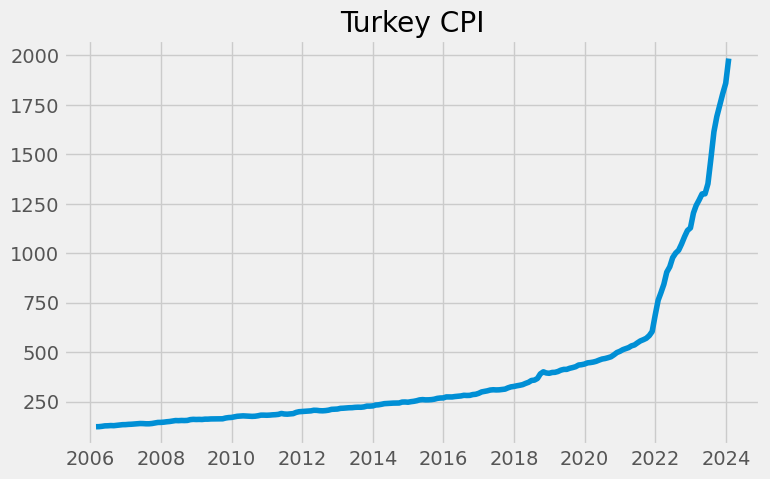

In [1555]:
dates=pd.date_range(start="2006-02-28",periods=len(enf) , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [1556]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857


In [1557]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del money["YEARWEEK"]
money=pd.DataFrame(money)
money.columns=["Tarih","Para Arzi"]
money=money.set_index(pd.to_datetime(money["Tarih"], format='%d-%m-%Y'))
del money["Tarih"]
money=money.resample('M').last()
money=money.pct_change(1)*100
money=money.dropna()
money

,Para Arzi
Tarih,
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2023-10-31,3.356297
2023-11-30,2.245991
2023-12-31,4.333376


In [1558]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
Tarih,
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-10-31,130.934676
2023-11-30,134.161244
2023-12-31,140.183543


In [1559]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",periods=len(issizlik),freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-08-31,9.1
2023-09-30,9.0
2023-10-31,8.5
2023-11-30,9.0


In [1560]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-10-31,88.704091
2023-11-30,82.027727
2023-12-31,77.324000


In [1561]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
del kredi["Tarih"]
del kredi["YEARWEEK"]
kredi=kredi.set_index(pd.date_range(start="2006-02-03",periods=len(kredi),freq="W"))
kredi.columns=["Kredi"]
kredi=(kredi.pct_change(4)*100).dropna()
kredi=kredi.resample('M').last()
kredi

,Kredi
2006-03-31,4.327119
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.364474
2006-07-31,-0.493205
...,...
2023-10-31,2.154973
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,1.789324


In [1562]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-03-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-03-28',periods=len(df3) , freq='1M'))
df3

,Kredi
2006-03-31,4.327119
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.364474
2006-07-31,-0.493205
...,...
2023-10-31,2.154973
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,1.789324


In [1563]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
212,2023-10,33.00
213,2023-11,41.09
214,2023-12,42.50
215,2024-1,44.00


In [1564]:
dates=pd.date_range('2006-02-28',periods=len(pfaiz) , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50


In [1565]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del kfaiz["Tarih"]
del kfaiz["YEARWEEK"]
kfaiz=kfaiz.set_index(pd.date_range(start="2006-02-01",periods=len(kfaiz),freq="1W"))
kfaiz=kfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])
kfaiz.columns=["Kredi Faizi"]
kfaiz

,Kredi Faizi
2006-02-28,17.02
2006-03-31,16.88
2006-04-30,15.84
2006-05-31,16.60
2006-06-30,20.35
...,...
2023-10-31,58.43
2023-11-30,58.61
2023-12-31,58.16
2024-01-31,59.41


In [1566]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",periods=len(perakende1),freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-08-31,185.330997,183.564524,176.254302
2023-09-30,184.673020,183.157065,174.785903
2023-10-31,182.582955,180.947621,178.237289
2023-11-30,183.908595,182.048518,178.930674


In [1567]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",periods=len(motorin),freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-10-31,38.900000
2023-11-30,37.680000
2023-12-31,36.420000
2024-01-31,39.450000


In [1568]:
sanayi=pd.read_excel("./sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-08-31,146.075796
2023-09-30,145.853837
2023-10-31,145.491300
2023-11-30,143.444185


In [1569]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="03-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
#mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["YEARWEEK"]
del mfaiz["Tarih"]
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-03",periods=len(mfaiz),freq="W"))
mfaiz=mfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])

mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.70
2006-03-31,14.84
2006-04-30,14.87
2006-05-31,14.84
2006-06-30,15.57
...,...
2023-10-31,41.72
2023-11-30,46.07
2023-12-31,52.50
2024-01-31,49.61


In [1570]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",periods=len(enf_belirsizlik),freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-10-31,5.57
2023-11-30,4.49
2023-12-31,3.36
2024-01-31,3.50


In [1571]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",periods=len(borc),freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.086466e+09


In [1572]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",periods=len(redk),freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-09-30,89.21
2023-10-31,89.10
2023-11-30,87.36
2023-12-31,85.93


In [1573]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",periods=len(redkt),freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-09-30,55.53
2023-10-31,56.05
2023-11-30,55.27
2023-12-31,55.29


In [1574]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"].rolling(3).mean()
#data["USD/TL2"]=df6["USD/TL"]
#data["USD/TL3"]=df6["USD/TL"]**2
#data["USD/TL4"]=df6["USD/TL"]**3
#data["USD/TL5"]=df6["USD/TL"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["Borç"]=(borc["Borç"]).shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change()*100
data

,USD/TL,Motorin,Perakende Satış,Sanayi,M3,Borç,TÜFE
Tarih,,,,,,,
2006-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-31,NaN,0.975610,NaN,2.437308,NaN,1.177123,0.274548
2006-04-30,NaN,2.898551,NaN,-0.738864,2.564688,-0.027189,1.336769
2006-05-31,2.353679,4.694836,NaN,0.882710,1.323922,0.123397,1.875397
2006-06-30,6.483947,5.829596,NaN,0.536906,9.308200,1.649207,0.335413
...,...,...,...,...,...,...,...
2023-10-31,1.709911,-0.714650,1.974636,-0.248562,2.614384,3.653039,3.433981
2023-11-30,2.001541,-3.136247,0.389023,-1.407036,3.374057,3.741984,3.281097
2023-12-31,2.498315,-3.343949,1.735783,2.411073,2.464258,4.034830,2.927207


In [1575]:

data["Kredi"]=df3["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["Zam"]=0
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','İşsizlik','Politika Faizi','TÜFE']]
data.iloc[11:23,4]=12.3
data.iloc[23:35,4]=29.32
data.iloc[35:47,4]=7.92
data.iloc[47:59,4]=14.17
data.iloc[59:71,4]=25.45
data.iloc[71:83,4]=15
data.iloc[83:95,4]=8
data.iloc[95:107,4]=846
data.iloc[107:119,4]=949.07
data.iloc[119:131,4]=1300.99
data.iloc[131:143,4]=1404.6
data.iloc[143:155,4]=1603.12
data.iloc[155:167,4]=2020.59
data.iloc[167:179,4]=2324.70
data.iloc[179:191,4]=2825.90
data.iloc[191:197,4]=4253.40
data.iloc[197:203,4]=5500.35
data.iloc[203:209,4]=8506.80
data.iloc[209:,4]=11402.32
#data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data=data.loc["2014-01-31":"2024-01-31"]
#data.iloc[0,4]=14.2
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.80,846.00,3.604096,0.82,3.375162,-0.584687,2.669930,8.85,91.32,95.75,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.54,846.00,-0.850238,0.73,1.804994,0.808574,1.876850,10.75,93.31,96.63,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,16.05,846.00,0.128936,0.80,0.451349,0.193691,0.822203,11.65,93.75,97.25,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.65,846.00,-0.863760,0.73,0.796760,0.478162,-0.154556,10.75,98.14,102.98,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.36,846.00,-1.367417,0.80,-0.362357,0.091080,0.146305,10.43,99.40,105.10,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,5.071342,4.843457,-0.833114,57.56,11402.32,-0.151948,7.30,4.764088,4.384930,2.048237,42.74,89.21,55.53,9.0,31.00,4.753114
2023-10-31,1.709911,-0.714650,1.974636,58.43,11402.32,-0.248562,5.57,2.694232,3.653039,1.782758,41.72,89.10,56.05,8.5,33.00,3.433981
2023-11-30,2.001541,-3.136247,0.389023,58.61,11402.32,-1.407036,4.49,3.356297,3.741984,2.499767,46.07,87.36,55.27,9.0,41.09,3.281097


In [1576]:
data["Zam"]=data["Zam"].pct_change()*100

In [1577]:
data.iloc[0,4]=14.2

In [1578]:
data1=data[:-2]

In [1579]:
data1=data1.diff()
data1=data1.dropna()

<Axes: title={'center': 'TÜFE ile Korelasyonlar'}>

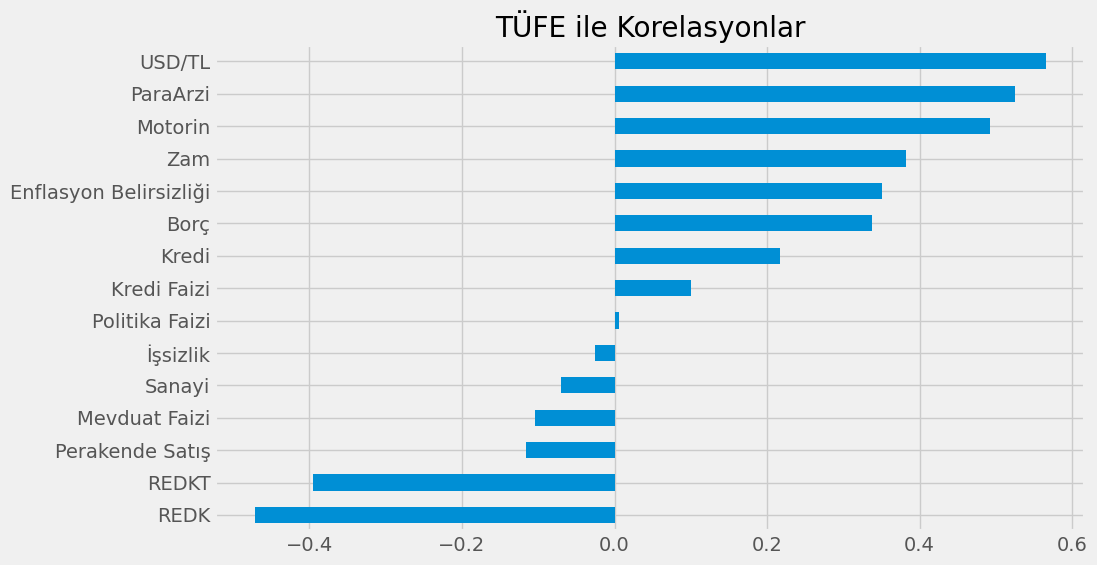

In [1580]:
cor_matrix=data1.corr()
cor_matrix=(cor_matrix["TÜFE"]).sort_values(ascending=True)
cor_matrix[:-1].plot(kind="barh",title="TÜFE ile Korelasyonlar",figsize=(10,6))

In [1581]:
data=data.drop(["Perakende Satış","Kredi Faizi","Sanayi"],axis=1)

In [1582]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[-8:,0]},index=pd.date_range(start="2023-08-30",periods=7,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,37.5,35,35,35,35,35,35,35,32.5,30,27.5,25,25,25,25,25]
faiztahmin

,Politika Faizi
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50
2024-01-31,45.00
2024-02-29,45.00
2024-03-31,45.00
2024-04-30,45.00
2024-05-31,45.00


In [1583]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,X=np.array(pfaiz["Politika Faizi"]).reshape(-1,1),information_criterion="aic",m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(25,X=np.array(faiztahmin["Politika Faizi"][7:]).reshape(-1,1))
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[211:,0]},index=kfaiz.index[211:])
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-09-30,57.560000
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,58.160000
2024-01-31,59.410000
2024-02-29,60.010000
2024-03-31,60.413621
2024-04-30,61.122954
2024-05-31,61.655503
2024-06-30,61.770230


In [1584]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.76
2010-02-28,13.36
2010-03-31,13.10
2010-04-30,13.18
2010-05-31,13.25
...,...
2023-08-31,45.29
2023-09-30,57.56
2023-10-31,58.43
2023-11-30,58.61


In [1585]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-11-30,58.610000
2023-12-31,58.160000
2024-01-31,59.410000
2024-02-29,60.010000
2024-03-31,60.413621
2024-04-30,61.122954
2024-05-31,61.655503
2024-06-30,61.770230
2024-07-31,61.528492
2024-08-31,61.169981


In [1586]:
faiztahmin[5:]

,Politika Faizi
2024-01-31,45.0
2024-02-29,45.0
2024-03-31,45.0
2024-04-30,45.0
2024-05-31,45.0
2024-06-30,45.0
2024-07-31,45.0
2024-08-31,45.0
2024-09-30,45.0
2024-10-31,42.5


In [1587]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz,trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(26,X=faiztahmin[6:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2024-01-30",periods=2,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2024-01-31,49.610000
2024-02-29,50.930000
2024-03-31,53.908890
2024-04-30,51.541516
2024-05-31,51.461717
2024-06-30,53.139388
2024-07-31,51.812836
2024-08-31,51.762362
2024-09-30,52.707180
2024-10-31,51.963871


In [1588]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [1589]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-10-31,2432.069312
2023-11-30,2316.594077
2023-12-31,2231.258978
2024-01-31,2341.408383


In [1590]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [1591]:
faiztahmin.columns=["Faiz"]


In [1592]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [1593]:
exog=pfaiz["Politika Faizi"].iloc[95:-2]
exog=np.array(exog).reshape(-1,1)

In [1594]:
exogtest=faiztahmin.iloc[4:]
exogtest=np.array(exogtest).reshape(-1,1)

In [1595]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-01-31,8.716523
2024-02-29,8.924516
2024-03-31,8.923326
2024-04-30,8.951931
2024-05-31,9.068261
2024-06-30,9.116040
2024-07-31,9.170229
2024-08-31,9.248216
2024-09-30,9.303553
2024-10-31,9.358690


In [1596]:
from prophet import Prophet


In [1597]:
df6.shape

(217, 1)

In [1598]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6.index
    sn["y"]=df6.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df6.values,predictions["yhat"][:-13])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6.index\n    sn["y"]=df6.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],se

In [1599]:
"""study.best_params"""

'study.best_params'

In [1600]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.966616002895412,changepoint_range=0.9704631745207867,seasonality_prior_scale=6.536685782383086,n_changepoints=78,interval_width=0.70,yearly_seasonality=False,weekly_seasonality=False)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:26 - cmdstanpy - INFO - Chain [1] start processing
23:07:27 - cmdstanpy - INFO - Chain [1] done processing


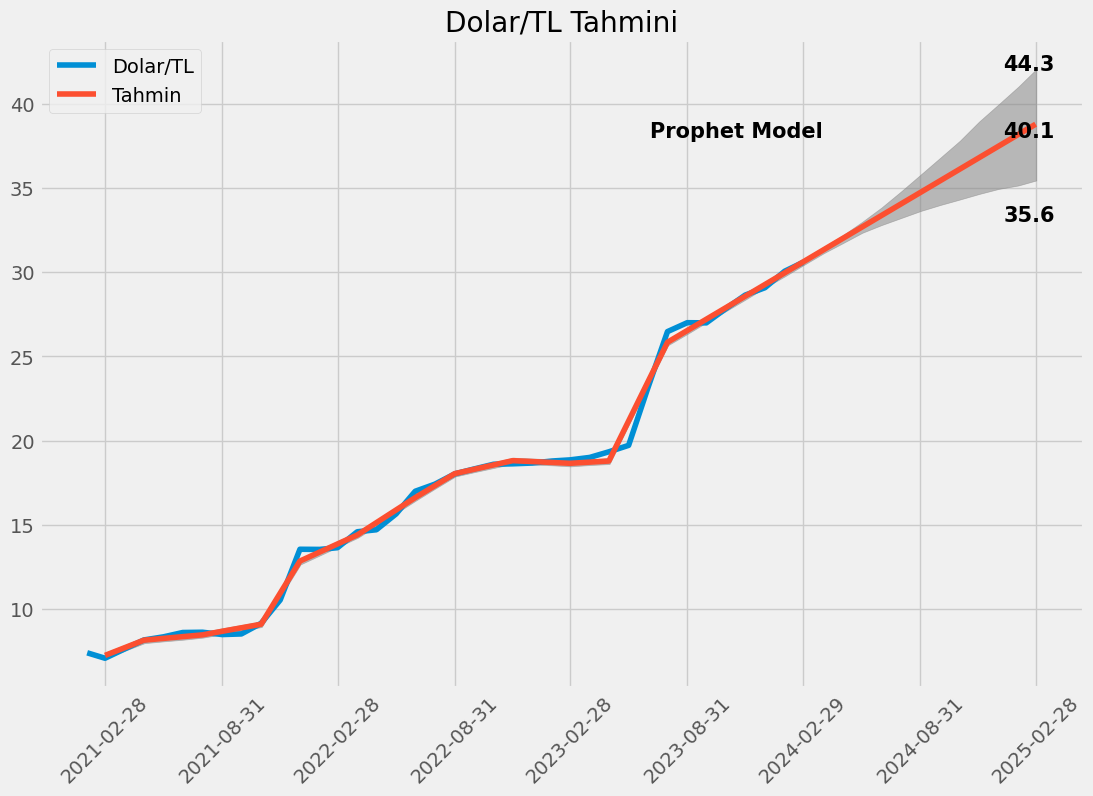

In [1601]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
plt.plot(df6["USD/TL"][-38:],label='Dolar/TL')
plt.plot(predictions["yhat"][-51:-2],label='Tahmin')
annotation_date = mdates.datestr2num('2025-03-30')
annotation_date1 = mdates.datestr2num('2024-03-30')
plt.text(annotation_date1, 38,  "Prophet Model",fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 38,  str(predictions["yhat"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 33,  str(predictions["yhat_lower"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 42,  str(predictions["yhat_upper"][-1])[:4],fontsize=15, color='black', horizontalalignment='right',fontweight='bold')
plt.fill_between(predictions["yhat"][-51:-1].index.strftime("%Y-%m"), predictions["yhat_upper"][-51:-1].shift(1), predictions["yhat_lower"][-51:-1].shift(1), alpha=0.5, color='gray')
plt.xticks(predictions.index[-51:-2:6],rotation=45)
plt.title('Dolar/TL Tahmini')
plt.legend(loc=2)

In [1602]:
usdtahmin=(predictions["yhat"][-15:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-03-31    2.267614
2024-04-30    2.145806
2024-05-31    2.170753
2024-06-30    2.056096
2024-07-31    2.081828
2024-08-31    2.039372
2024-09-30    1.934141
2024-10-31    1.960690
2024-11-30    1.860955
2024-12-31    1.887854
2025-01-31    1.852875
2025-02-28    1.643119
2025-03-31    1.789760
2025-04-30    1.701572
Name: yhat, dtype: float64

In [1603]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-6:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-09-30", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.074857
2024-01-31,30.053750
2024-02-29,30.586475
2024-03-31,31.280058
2024-04-30,31.951267
2024-05-31,32.644850
2024-06-30,33.316060


In [1604]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [1605]:
"""study.best_params"""

'study.best_params'

In [1606]:
sn=pd.DataFrame()
sn["ds"]=df14[50:].index
sn["y"]=df14[50:].values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.441645091305189,changepoint_range=0.9896533088928638,seasonality_prior_scale=6.984796984939141,n_changepoints=96)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing


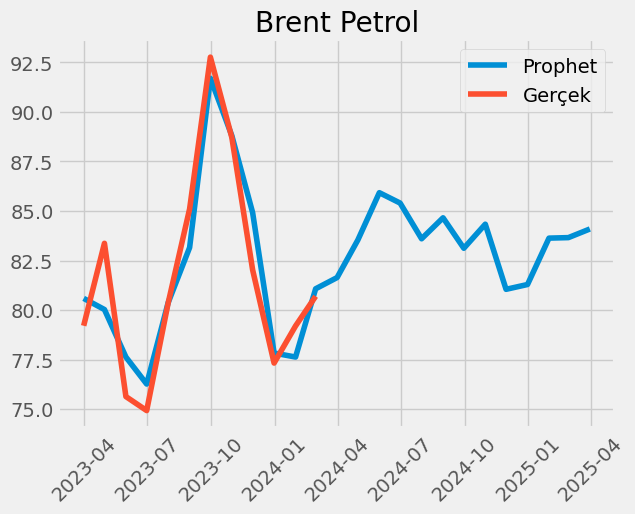

In [1607]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-25:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1608]:
brenttahmin=predictions["yhat"][-17:]
brenttahmin

ds
2023-11-30    84.917894
2023-12-31    77.829604
2024-01-31    77.628042
2024-02-29    81.073432
2024-03-31    81.640042
2024-04-30    83.539274
2024-05-31    85.924022
2024-06-30    85.399727
2024-07-31    83.597873
2024-08-31    84.657184
2024-09-30    83.119178
2024-10-31    84.333834
2024-11-30    81.046549
2024-12-31    81.289133
2025-01-31    83.630273
2025-02-28    83.656009
2025-03-31    84.091691
Name: yhat, dtype: float64

In [1609]:
"""brenttahmin=pd.read_csv("C:/Users/Bora/Downloads/brent_forecast.csv")
brenttahmin=brenttahmin.set_index(brenttahmin["Unnamed: 0"])
del brenttahmin["Unnamed: 0"]
brenttahmin.index.name="" 
brenttahmin"""

'brenttahmin=pd.read_csv("C:/Users/Bora/Downloads/brent_forecast.csv")\nbrenttahmin=brenttahmin.set_index(brenttahmin["Unnamed: 0"])\ndel brenttahmin["Unnamed: 0"]\nbrenttahmin.index.name="" \nbrenttahmin'

In [1610]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

In [1611]:
"""study.best_params"""

'study.best_params'

23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing


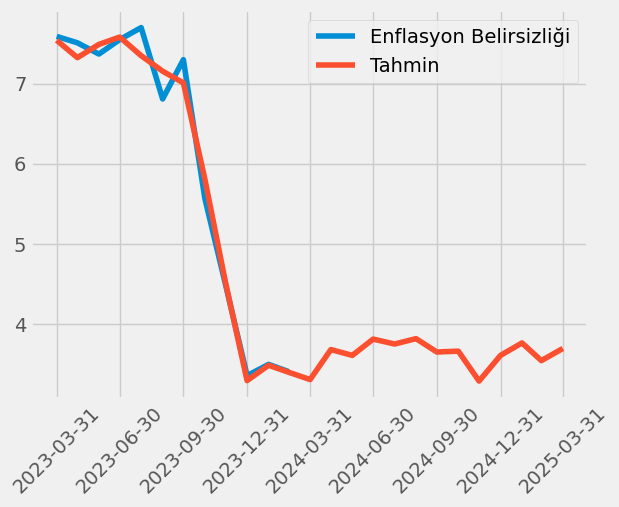

In [1612]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=8.955223108186987,changepoint_range=0.989253264197194,seasonality_prior_scale=1.9588517444428757,n_changepoints=44,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()


In [1613]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-14:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-02-29,3.410000
2024-03-31,3.310984
2024-04-30,3.684711
2024-05-31,3.612257
2024-06-30,3.815501
2024-07-31,3.754274
2024-08-31,3.820994
2024-09-30,3.654365
2024-10-31,3.665131


In [1614]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [1615]:
#study.best_params

In [1616]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].values
sn["cap"]=190
prophet=Prophet(changepoint_prior_scale=3.481321992729419,changepoint_range=0.8995930316928846,growth='linear',seasonality_prior_scale=8.977376335194005,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=190
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:31 - cmdstanpy - INFO - Chain [1] start processing
23:07:31 - cmdstanpy - INFO - Chain [1] done processing


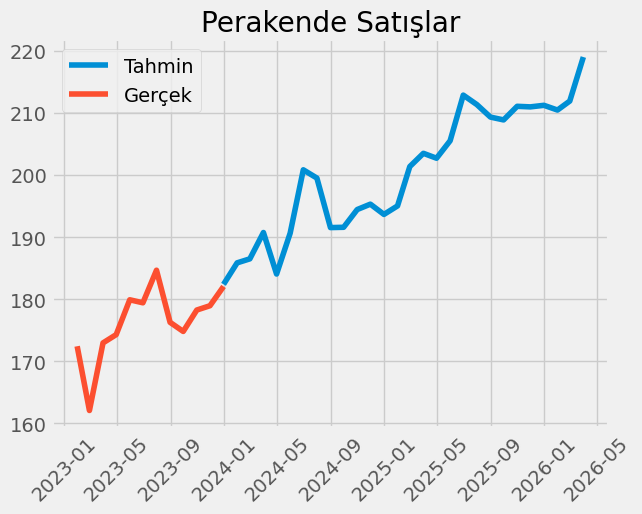

In [1617]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-28:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1618]:
perakendetahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2024-01-31    1.899453
2024-02-29    0.347187
2024-03-31    2.275449
2024-04-30   -3.506735
2024-05-31    3.578296
2024-06-30    5.356224
2024-07-31   -0.663651
2024-08-31   -3.999949
2024-09-30    0.025459
2024-10-31    1.493126
2024-11-30    0.446150
2024-12-31   -0.845813
2025-01-31    0.708612
2025-02-28    3.251780
2025-03-31    1.059153
2025-04-30   -0.388384
2025-05-31    1.389245
2025-06-30    3.578033
2025-07-31   -0.716229
2025-08-31   -0.953721
2025-09-30   -0.217622
2025-10-31    1.049791
2025-11-30   -0.043539
2025-12-31    0.119629
2026-01-31   -0.361156
2026-02-28    0.688540
2026-03-31    3.348129
Name: yhat, dtype: float64

In [1619]:
((usdtahmin1[2:-1].pct_change(periods=1)*100).dropna())

,USD/TL
2023-12-31,1.528701
2024-01-31,3.366802
2024-02-29,1.772574
2024-03-31,2.267614
2024-04-30,2.145806
2024-05-31,2.170753
2024-06-30,2.056096
2024-07-31,2.081828
2024-08-31,2.039372
2024-09-30,1.934141


In [1620]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2023-12-31   -8.347227
2024-01-31   -0.258978
2024-02-29    4.438332
2024-03-31    0.698885
2024-04-30    2.326349
2024-05-31    2.854643
2024-06-30   -0.610185
2024-07-31   -2.109906
2024-08-31    1.267151
2024-09-30   -1.816746
2024-10-31    1.461342
2024-11-30   -3.897943
2024-12-31    0.299314
2025-01-31    2.880016
2025-02-28    0.030774
2025-03-31    0.520801
Name: yhat, dtype: float64

In [1621]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:-1].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-12-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-12-31,5.678074
2024-01-31,3.099104
2024-02-29,6.289578
2024-03-31,2.982346
2024-04-30,4.522074
2024-05-31,5.087364
2024-06-30,1.433365
2024-07-31,-0.072003
2024-08-31,3.332365
2024-09-30,0.082257


In [1622]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [1623]:
"""study.best_params"""

'study.best_params'

In [1624]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=4.9385825316091445,changepoint_range=0.9538315586393957,growth='linear',seasonality_prior_scale=4.314940386271349,n_changepoints=76,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:32 - cmdstanpy - INFO - Chain [1] start processing
23:07:33 - cmdstanpy - INFO - Chain [1] done processing


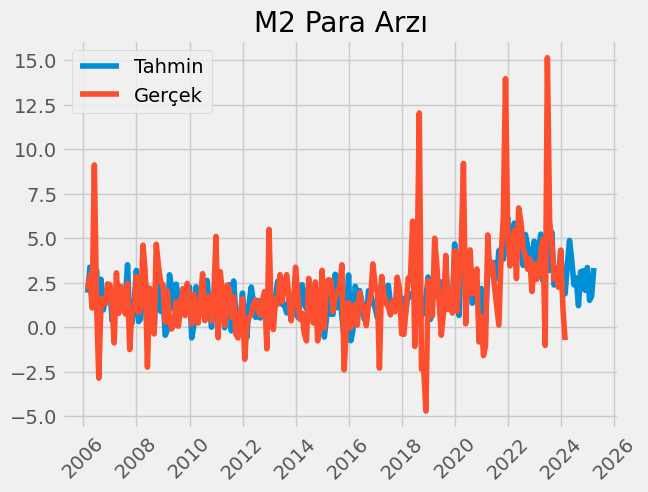

In [1625]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(money["Para Arzi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1626]:
paraarzitahmin=(predictions["yhat"]).tail(14)
paraarzitahmin

ds
2024-02-29    1.883419
2024-03-31    3.510266
2024-04-30    4.885013
2024-05-31    3.761025
2024-06-30    2.385055
2024-07-31    2.780631
2024-08-31    1.216298
2024-09-30    3.119446
2024-10-31    3.173362
2024-11-30    2.077606
2024-12-31    3.360508
2025-01-31    1.512138
2025-02-28    1.743829
2025-03-31    3.331431
Name: yhat, dtype: float64

In [1627]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-4:-1,0]},index=pd.date_range(start="2023-11-30",periods=3,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

,Para Arzi
2023-11-30,2.245991
2023-12-31,4.333376
2024-01-31,0.993354
2024-02-29,1.883419
2024-03-31,3.510266
2024-04-30,4.885013
2024-05-31,3.761025
2024-06-30,2.385055
2024-07-31,2.780631
2024-08-31,1.216298


In [1628]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [1629]:
#study.best_params

In [1630]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"][103:].index
sn["y"]=borc["Borç"][103:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=3.671534257218686,changepoint_range=0.8995013103592469,growth='linear',seasonality_prior_scale=4.464356522636207,n_changepoints=2)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=26,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:34 - cmdstanpy - INFO - Chain [1] start processing
23:07:34 - cmdstanpy - INFO - Chain [1] done processing


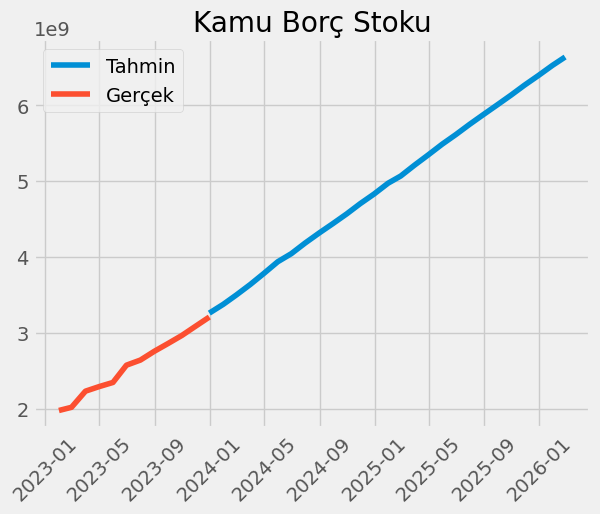

In [1631]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][-27:],label="Tahmin")
plt.plot(borc["Borç"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1632]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(26)
borctahmin

ds
2024-01-31    3.549683
2024-02-29    3.641687
2024-03-31    3.952185
2024-04-30    3.974986
2024-05-31    4.087029
2024-06-30    2.691098
2024-07-31    3.494913
2024-08-31    3.137333
2024-09-30    2.820024
2024-10-31    2.915254
2024-11-30    2.952763
2024-12-31    2.718657
2025-01-31    2.932624
2025-02-28    1.902385
2025-03-31    2.850371
2025-04-30    2.554249
2025-05-31    2.642735
2025-06-30    2.279607
2025-07-31    2.435279
2025-08-31    2.266843
2025-09-30    2.116154
2025-10-31    2.167006
2025-11-30    2.144938
2025-12-31    2.035404
2026-01-31    2.078257
2026-02-28    1.680028
Name: yhat, dtype: float64

In [1633]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(borctahmin1), freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-09-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.086466e+09
2023-12-31,3.209252e+09
2024-01-31,3.323170e+09
2024-02-29,3.444190e+09
2024-03-31,3.580310e+09
2024-04-30,3.722627e+09
2024-05-31,3.874772e+09
2024-06-30,3.979046e+09


In [1634]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 15),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,15),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 15),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,15),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growt

In [1635]:
"""study.best_params"""

'study.best_params'

In [1636]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"].index
sn["y"]=df3["Kredi"].values
prophet=Prophet(changepoint_prior_scale=14.571144908454663,changepoint_range=0.8904873855141803,growth="linear",seasonality_prior_scale=1.5574317873100854,n_changepoints=192,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:35 - cmdstanpy - INFO - Chain [1] start processing
23:07:36 - cmdstanpy - INFO - Chain [1] done processing


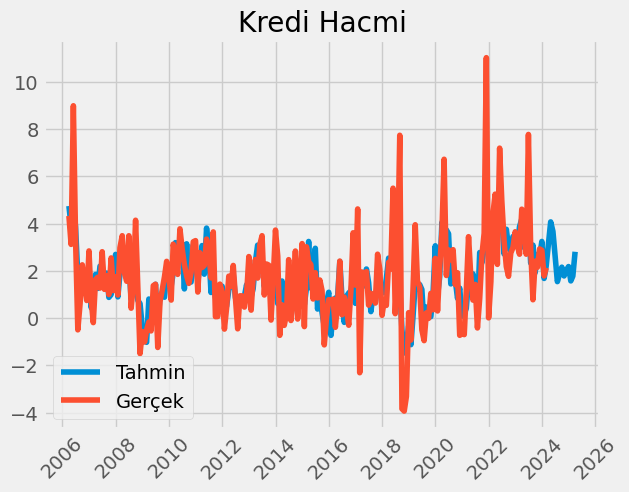

In [1637]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df3["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1638]:
kreditahmin=(predictions["yhat"]).tail(13)
kreditahmin

ds
2024-03-31    3.155929
2024-04-30    4.077383
2024-05-31    3.674582
2024-06-30    2.619656
2024-07-31    1.547593
2024-08-31    1.888246
2024-09-30    2.160253
2024-10-31    1.788396
2024-11-30    2.021870
2024-12-31    2.186055
2025-01-31    1.578363
2025-02-28    1.781273
2025-03-31    2.812108
Name: yhat, dtype: float64

In [1639]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":df3.iloc[-4:,0]},index=pd.date_range(start="2023-11-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2023-11-30,2.932091
2023-12-31,2.873464
2024-01-31,1.789324
2024-02-29,2.132673
2024-03-31,3.155929
2024-04-30,4.077383
2024-05-31,3.674582
2024-06-30,2.619656
2024-07-31,1.547593
2024-08-31,1.888246


In [1640]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index
    sn["y"]=m3["M3 Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3 Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index\n    sn["y"]=m3["M3 Para Arzi"][

In [1641]:
#study.best_params

In [1642]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"][151:].index
sn["y"]=m3["M3 Para Arzi"][151:].values
sn["cap"]=386.728728252815
prophet=Prophet(changepoint_prior_scale=1.0239522189165728,changepoint_range=0.8631788185438879,growth='logistic',seasonality_prior_scale=8.271825948806738,n_changepoints=14,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=386.728728252815
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:37 - cmdstanpy - INFO - Chain [1] start processing
23:07:38 - cmdstanpy - INFO - Chain [1] done processing


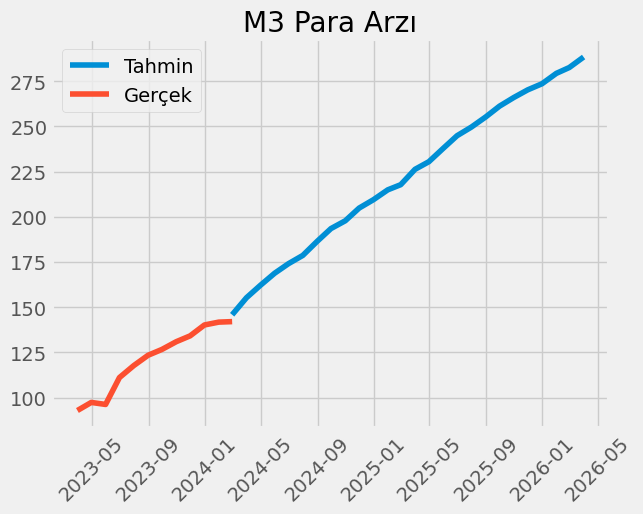

In [1643]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(m3["M3 Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1644]:
m3tahmin=(predictions["yhat"].tail(26).pct_change(periods=1)*100).dropna()
m3tahmin1 = []
result = m3.iloc[-1,0]
for i in range(len(m3tahmin)):
    result *= (1 + m3tahmin[i] / 100)
    m3tahmin1.append(result)

m3tahmin1 = np.array(m3tahmin1).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2023-10-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2023-10-31,NaN
2023-11-30,134.161244
2023-12-31,140.183543
2024-01-31,141.754955
2024-02-29,151.204774
2024-03-31,157.861695
2024-04-30,164.403208
2024-05-31,169.551584
2024-06-30,174.002012
2024-07-31,181.558374


In [1645]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [1646]:
#study.best_params

In [1647]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
prophet=Prophet(changepoint_prior_scale=9.619978429571834,changepoint_range=0.8872026398316396,growth='linear',seasonality_prior_scale=4.66384076344283,n_changepoints=25,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:39 - cmdstanpy - INFO - Chain [1] start processing
23:07:39 - cmdstanpy - INFO - Chain [1] done processing


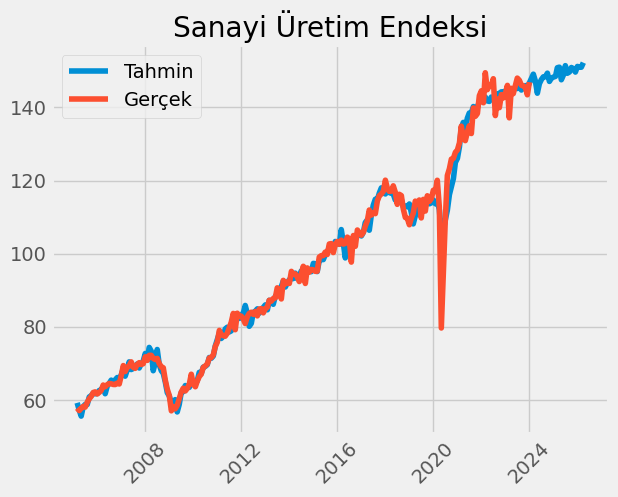

In [1648]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1649]:
sanayitahmin=(predictions["yhat"].tail(27).pct_change(periods=1)*100).dropna()
sanayitahmin1 = []
result = sanayi.iloc[-1,0]
for i in range(len(sanayitahmin)):
    result *= (1 + sanayitahmin[i] / 100)
    sanayitahmin1.append(result)

sanayitahmin1 = np.array(sanayitahmin1).reshape(-1, 1)
sanayitahmin1 = pd.DataFrame(sanayitahmin1)
sanayitahmin1.columns = ["Sanayi"]
sanayitahmin1 = sanayitahmin1.set_index(pd.date_range(start="2023-12-30", periods=len(sanayitahmin1), freq="1M"))
#row=pd.DataFrame({"Sanayi":df3.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
#sanayitahmin1=pd.concat([row,sanayitahmin1],axis=0)
sanayitahmin1

,Sanayi
2023-12-31,148.024954
2024-01-31,146.176761
2024-02-29,142.855890
2024-03-31,145.442474
2024-04-30,146.545767
2024-05-31,147.312299
2024-06-30,147.327858
2024-07-31,148.298141
2024-08-31,146.062605
2024-09-30,146.954653


In [1650]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"][params["m"]:-36].index
    sn["y"]=redkt["REDKT"][params["m"]:-36].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"][-36:],predictions["yhat"][-36:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"][params["m"]:-36].index\n    sn["y"]=redkt["REDKT"][params[

In [1651]:
#study.best_params

In [1652]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=300
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=300
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:40 - cmdstanpy - INFO - Chain [1] start processing
23:07:40 - cmdstanpy - INFO - Chain [1] done processing


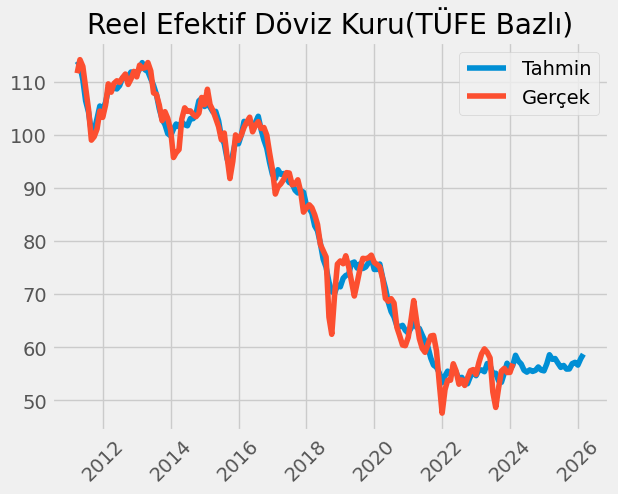

In [1653]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1654]:
predictions["yhat"].tail(26)

ds
2024-01-31    56.640100
2024-02-29    58.505198
2024-03-31    57.417650
2024-04-30    56.866533
2024-05-31    55.688714
2024-06-30    55.337045
2024-07-31    55.762017
2024-08-31    55.475035
2024-09-30    55.670413
2024-10-31    56.308064
2024-11-30    55.729598
2024-12-31    55.578815
2025-01-31    56.927392
2025-02-28    58.611467
2025-03-31    57.755819
2025-04-30    57.894979
2025-05-31    57.017113
2025-06-30    56.233545
2025-07-31    56.589685
2025-08-31    55.913466
2025-09-30    55.936030
2025-10-31    56.931289
2025-11-30    57.175237
2025-12-31    56.663824
2026-01-31    57.878159
2026-02-28    58.719425
Name: yhat, dtype: float64

In [1655]:
redkttahmin=predictions["yhat"].tail(26)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redkttahmin.iloc[0,0]=redkt.iloc[-1,0]
redkttahmin

,REDKT
2023-12-31,56.950000
2024-01-31,58.505198
2024-02-29,57.417650
2024-03-31,56.866533
2024-04-30,55.688714
2024-05-31,55.337045
2024-06-30,55.762017
2024-07-31,55.475035
2024-08-31,55.670413
2024-09-30,56.308064


In [1656]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-13))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scale=par

In [1657]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
prophet=Prophet(changepoint_prior_scale=6.258111900769947,changepoint_range=0.9753144235744484,growth='linear',seasonality_prior_scale=0.16965698744688584,n_changepoints=99,yearly_seasonality=True,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

23:07:41 - cmdstanpy - INFO - Chain [1] start processing
23:07:42 - cmdstanpy - INFO - Chain [1] done processing


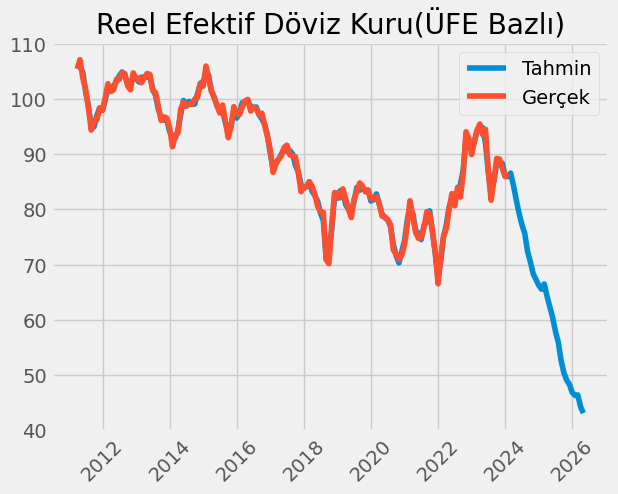

In [1658]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [1659]:
predictions["yhat"].tail(28)

ds
2024-01-31    85.916264
2024-02-29    86.563648
2024-03-31    84.270804
2024-04-30    81.694536
2024-05-31    79.246497
2024-06-30    77.250735
2024-07-31    75.625077
2024-08-31    72.366635
2024-09-30    70.506671
2024-10-31    68.332527
2024-11-30    67.318063
2024-12-31    66.224301
2025-01-31    65.516070
2025-02-28    66.476094
2025-03-31    64.243414
2025-04-30    62.381958
2025-05-31    60.404861
2025-06-30    57.918311
2025-07-31    55.933331
2025-08-31    52.561945
2025-09-30    50.420743
2025-10-31    49.051611
2025-11-30    48.275913
2025-12-31    46.774946
2026-01-31    46.283765
2026-02-28    46.380136
2026-03-31    44.229643
2026-04-30    43.089729
Name: yhat, dtype: float64

In [1660]:
redktahmin=predictions["yhat"].tail(28)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redktahmin),freq="1M"))
redktahmin.iloc[0,0]=redk.iloc[-1,0]
redktahmin

,REDK
2023-12-31,86.530000
2024-01-31,86.563648
2024-02-29,84.270804
2024-03-31,81.694536
2024-04-30,79.246497
2024-05-31,77.250735
2024-06-30,75.625077
2024-07-31,72.366635
2024-08-31,70.506671
2024-09-30,68.332527


In [1661]:
motorintahmin.iloc[2]=5.6781
motorintahmin.iloc[1]=8.3196
motorintahmin.iloc[0]=-3.34

In [1662]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 2),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.001,1.0),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoinst',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=historical_volatility.index
    sn["y"]=historical_volatility.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 2),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.001,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoinst\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=historical_volatility.index\n    sn["y"]=historical_volatility.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predict

In [1663]:
"""study.best_params"""

'study.best_params'

In [1664]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),sanayitahmin1["Sanayi"],m3tahmin1["M3"].shift(1),borctahmin1.shift(1)],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Para Arzi"]=paraarzitahmin1.shift(1)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["REDK"]=redktahmin["REDK"]
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende Satış"]=perakendetahmin




tahmindf["Politika Faizi"]=[42.5,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,42.5,40]
tahmindf=tahmindf[['USD/TL', 'Motorin', 'Kredi Faizi', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT','REDK','İşsizlik','Politika Faizi',"Sanayi","Perakende Satış"]]

tahmindf.columns=["USD/TL","Motorin","Kredi Faizi","Zam","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT','REDK','İşsizlik','Politika Faizi',"Sanayi","Perakende Satış"]
tahmindf=tahmindf.dropna(axis=0)










tahmindf.iloc[0,1]=9.5
tahmindf.iloc[0,-5]=87.50
tahmindf.iloc[0,-6]=57.59
tahmindf

,USD/TL,Motorin,Kredi Faizi,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDKT,REDK,İşsizlik,Politika Faizi,Sanayi,Perakende Satış
2024-02-29,2.221133,9.500000,60.010000,0.0,3.410000,0.993354,3.549683,2.265154,50.930000,57.590000,87.500000,8.924516,45.0,-2.271819,0.347187
2024-03-31,2.458005,2.982346,60.413621,0.0,3.310984,1.883419,3.641687,2.359309,53.908890,56.866533,81.694536,8.923326,45.0,1.810625,2.275449
2024-04-30,2.064308,4.522074,61.122954,0.0,3.684711,3.510266,3.952185,3.121995,51.541516,55.688714,79.246497,8.951931,45.0,0.758577,-3.506735
2024-05-31,2.194014,5.087364,61.655503,0.0,3.612257,4.885013,3.974986,3.635965,51.461717,55.337045,77.250735,9.068261,45.0,0.523067,3.578296
2024-06-30,2.123574,1.433365,61.770230,0.0,3.815501,3.761025,4.087029,3.457207,53.139388,55.762017,75.625077,9.116040,45.0,0.010562,5.356224
2024-07-31,2.102267,-0.072003,61.528492,0.0,3.754274,2.385055,2.691098,2.613944,51.812836,55.475035,72.366635,9.170229,45.0,0.658587,-0.663651
2024-08-31,2.058982,3.332365,61.169981,0.0,3.820994,2.780631,3.494913,2.018499,51.762362,55.670413,70.506671,9.248216,45.0,-1.507460,-3.999949
2024-09-30,2.017443,0.082257,60.927303,0.0,3.654365,1.216298,3.137333,1.865364,52.707180,56.308064,68.332527,9.303553,45.0,0.610730,0.025459
2024-10-31,1.977547,3.450684,60.899773,0.0,3.665131,3.119446,2.820024,1.945632,51.963871,55.729598,67.318063,9.358690,45.0,0.192091,1.493126
2024-11-30,1.918120,-2.109527,61.038395,0.0,3.292412,3.173362,2.915254,1.990173,50.708596,55.578815,66.224301,9.431034,45.0,0.125485,0.446150


In [1665]:
data.iloc[-1,2]=49.11
data.iloc[-1,5]=borctahmin.iloc[0]
data.iloc[-1,-3]=9.0

In [1666]:
tahmindf=tahmindf.drop(["Sanayi","Perakende Satış","Kredi Faizi"],axis=1)

In [1667]:
data1=pd.concat([data,tahmindf],axis=0)
data1=data1[:-1]
data1

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
2014-01-31,3.732429,2.881984,14.2,0.820000,3.375162,-0.584687,2.669930,8.850000,91.320000,95.750000,9.200000,9.96,1.978080
2014-02-28,3.033477,1.685899,0.0,0.730000,1.804994,0.808574,1.876850,10.750000,93.310000,96.630000,9.500000,10.23,0.428192
2014-03-31,2.465778,-2.278097,0.0,0.800000,0.451349,0.193691,0.822203,11.650000,93.750000,97.250000,9.500000,10.27,1.125608
2014-04-30,-1.344724,-6.214384,0.0,0.730000,0.796760,0.478162,-0.154556,10.750000,98.140000,102.980000,9.700000,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.0,0.800000,-0.362357,0.091080,0.146305,10.430000,99.400000,105.100000,9.700000,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,1.977547,3.450684,0.0,3.665131,3.119446,2.820024,1.945632,51.963871,67.318063,55.729598,9.358690,45.00,NaN
2024-11-30,1.918120,-2.109527,0.0,3.292412,3.173362,2.915254,1.990173,50.708596,66.224301,55.578815,9.431034,45.00,NaN
2024-12-31,1.902702,2.192819,0.0,3.612474,2.077606,2.952763,1.998774,50.016932,65.516070,56.927392,9.494729,45.00,NaN
2025-01-31,1.867176,4.786254,30.0,3.767486,3.360508,2.718657,1.928762,48.376695,66.476094,58.611467,9.556564,45.00,NaN


In [1668]:
data1.loc["2023-05-31","TÜFE"]+=2.88
"""data1.loc["2023-10-31","TÜFE"]-=0.22
data1.loc["2023-11-30","TÜFE"]-=1.01
data1.loc["2023-12-31","TÜFE"]-=0.33"""

'data1.loc["2023-10-31","TÜFE"]-=0.22\ndata1.loc["2023-11-30","TÜFE"]-=1.01\ndata1.loc["2023-12-31","TÜFE"]-=0.33'

In [653]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler = StandardScaler()
scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,İşsizlik,Politika Faizi,TÜFE
0,0.454511,0.104672,1.139242,-0.652965,0.377551,-1.155269,0.595779,-0.853118,0.578057,1.051160,-1.181933,-0.617269,0.057024
1,0.238287,-0.062104,-0.299260,-0.686588,-0.206190,-0.506155,0.057339,-0.708355,0.778626,1.098117,-0.981424,-0.593576,-0.625907
2,0.062666,-0.614825,-0.299260,-0.660437,-0.709434,-0.792626,-0.658685,-0.639784,0.822972,1.131201,-0.981424,-0.590066,-0.318603
3,-1.116129,-1.163682,-0.299260,-0.686588,-0.581021,-0.660092,-1.321829,-0.708355,1.265432,1.436957,-0.847751,-0.611127,-0.221945
4,-1.275444,-0.375481,-0.299260,-0.660437,-1.011945,-0.840432,-1.117568,-0.732736,1.392425,1.550082,-0.847751,-0.655003,-0.640434
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,-0.088370,0.183969,-0.299260,0.409944,0.282484,0.430971,0.104037,2.431765,-1.841054,-1.084354,-1.075870,2.457591,NaN
130,-0.106754,-0.591320,-0.299260,0.270700,0.302528,0.475339,0.134277,2.336125,-1.951292,-1.092399,-1.027518,2.457591,NaN
131,-0.111523,0.008578,-0.299260,0.390272,-0.104841,0.492814,0.140116,2.283426,-2.022673,-1.020438,-0.984947,2.457591,NaN
132,-0.122514,0.370194,2.739829,0.448183,0.372103,0.383745,0.092584,2.158455,-1.925914,-0.930575,-0.943618,2.457591,NaN


In [474]:
from sklearn.model_selection import train_test_split
X=scaled_data
X=X.iloc[:,:-1][:-13]
y=scaled_data["TÜFE"][:-13]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X_train,X_test=X[:-12,:],X[-12:,:]
y_train,y_test=y[:-12],y[-12:]
#X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=0)


In [475]:
"""import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import keras
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
def objective(trial):
    # Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-4)
    units1 = trial.suggest_int('units1', 1, 128)
    batch_size = trial.suggest_int('batch_size', 2, 40)
    activation1 = trial.suggest_categorical('activation1', ['tanh'])
    optimizer = trial.suggest_categorical('optimizer', ['rmsprop'])
    layer_size=trial.suggest_int('layer_size',1,5)
    keras.utils.set_random_seed(42)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1])))
    if layer_size>1:
       for _ in range(layer_size-1):
          model.add(Dense(units=units1,activation=activation1))
    model.add(Dense(1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=100, batch_size=batch_size,verbose=0)

    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))

    return mse  # Return validation accuracy as the objective
"""

"import optuna\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense\nimport keras\nfrom keras import regularizers\nfrom keras.layers import LSTM, Dense, Dropout\ndef objective(trial):\n    # Define hyperparameters to be optimized\n    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-4)\n    units1 = trial.suggest_int('units1', 1, 128)\n    batch_size = trial.suggest_int('batch_size', 2, 40)\n    activation1 = trial.suggest_categorical('activation1', ['tanh'])\n    optimizer = trial.suggest_categorical('optimizer', ['rmsprop'])\n    layer_size=trial.suggest_int('layer_size',1,5)\n    keras.utils.set_random_seed(42)\n    model = Sequential()   \n    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1])))\n    if layer_size>1:\n       for _ in range(layer_size-1):\n          model.add(Dense(units=units1,activation=activation1))\n    model.add(Dense(1))\n\n    if optimizer == 'adam'

In [476]:
"""study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=200)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

"study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective\nstudy.optimize(objective, n_trials=200)  # You can adjust the number of trials\n\n# Print the best hyperparameters\nprint('Best hyperparameters:', study.best_params)"

In [477]:
import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.05,random_state=42)
model = Sequential()
model.add(Dense(units=74,activation="tanh",input_dim=(X_train.shape[1])))
model.add(Dense(units=74,activation="tanh"))
model.add(Dense(units=74,activation="tanh"))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=100, batch_size=38,verbose=1,validation_data=(X_val,y_val))

Epoch 1/100
3/3 [==============================] - 1s 178ms/step - loss: 1.0908 - mean_squared_error: 1.0908 - val_loss: 0.7932 - val_mean_squared_error: 0.7932
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.9494 - mean_squared_error: 0.9494 - val_loss: 0.7342 - val_mean_squared_error: 0.7342
Epoch 3/100
3/3 [==============================] - 0s 27ms/step - loss: 0.8705 - mean_squared_error: 0.8705 - val_loss: 0.6803 - val_mean_squared_error: 0.6803
Epoch 4/100
3/3 [==============================] - 0s 25ms/step - loss: 0.8090 - mean_squared_error: 0.8090 - val_loss: 0.6525 - val_mean_squared_error: 0.6525
Epoch 5/100
3/3 [==============================] - 0s 25ms/step - loss: 0.7558 - mean_squared_error: 0.7558 - val_loss: 0.6142 - val_mean_squared_error: 0.6142
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 0.7091 - mean_squared_error: 0.7091 - val_loss: 0.5832 - val_mean_squared_error: 0.5832
Epoch 7/100
3/3 [======================

KeyboardInterrupt: 

In [ ]:
mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(model.predict(X_test)))

1/1 [==============================] - 0s 130ms/step


0.7863707856438195

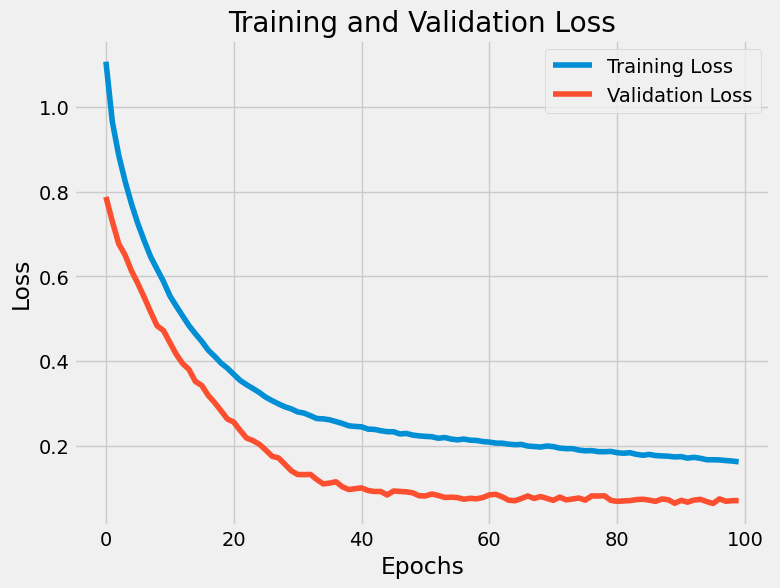

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tahminler=pd.DataFrame(index=pd.date_range(start="2023-02-28",periods=12,freq="1M"))
tahminler["TÜFE"]=scaler.inverse_transform(y_test)
tahminler["Tahmin"]=scaler.inverse_transform(model.predict(X_test))
tahminler.iloc[3,:]-=2.88
tahminler.iloc[8,1]+=0.22
tahminler.iloc[9,1]+=1.01
tahminler.iloc[10,1]+=0.29
tahminler

1/1 [==============================] - 0s 31ms/step


,TÜFE,Tahmin
2023-02-28,3.145046,2.364005
2023-03-31,2.289480,2.998156
2023-04-30,2.385509,3.236156
2023-05-31,0.043076,-0.050198
2023-06-30,3.920498,4.567596
2023-07-31,9.488824,9.278766
2023-08-31,9.086793,6.800575
2023-09-30,4.753114,4.926665
2023-10-31,3.433981,3.346244
2023-11-30,3.281097,3.454854


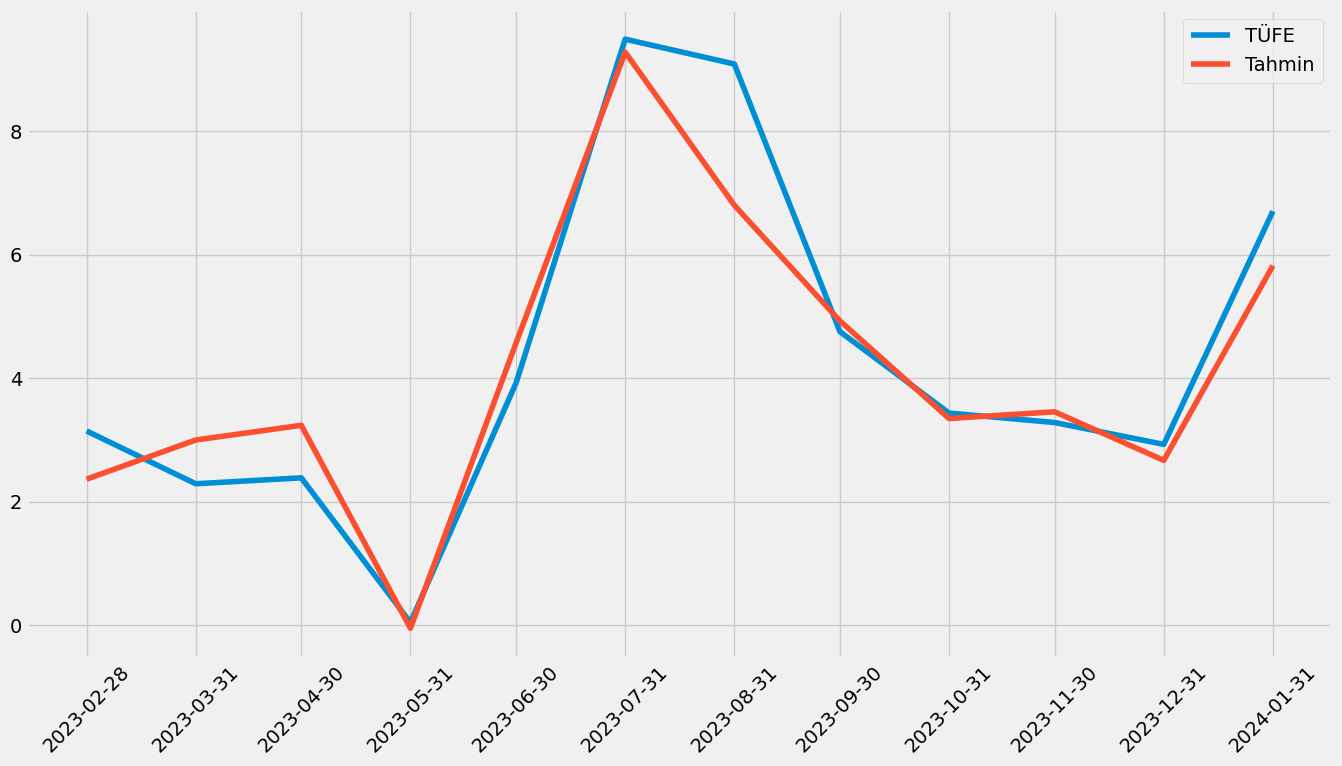

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(tahminler["TÜFE"],label="TÜFE")
plt.plot(tahminler["Tahmin"],label="Tahmin")
plt.xticks(tahminler.index,rotation=45)
plt.legend()
plt.show()

In [ ]:




import keras
from keras import Sequential
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)
from keras.regularizers import l2
keras.utils.set_random_seed(42)
model = Sequential()
model.add(LSTM(65,activation="tanh",input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X, y, epochs=100, batch_size=35,verbose=1)

Epoch 1/100
4/4 [==============================] - 3s 9ms/step - loss: 0.9683 - mean_squared_error: 0.9683
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9554 - mean_squared_error: 0.9554
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9444 - mean_squared_error: 0.9444
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9348 - mean_squared_error: 0.9348
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9172 - mean_squared_error: 0.9172
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9129 - mean_squared_error: 0.9129
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8970 - mean_squared_error: 0.8970
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.8808 - mean_squared_error: 0.8808
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 0.8775 - mean_squared_error: 0.8775
Epoch 10/100
4/4 [=================

In [ ]:
pred=scaler.inverse_transform(model.predict(np.array(scaled_data.iloc[-13:,:-1])))
pred=pd.DataFrame(pred)
pred.columns=["TÜFE"]
pred=pred.set_index(pd.date_range(start="2024-02-28",periods=13,freq="1M"))
pred

1/1 [==============================] - 1s 630ms/step


,TÜFE
2024-02-29,2.704535
2024-03-31,2.360283
2024-04-30,2.861029
2024-05-31,3.252257
2024-06-30,2.769244
2024-07-31,1.922754
2024-08-31,2.170336
2024-09-30,1.639378
2024-10-31,2.013628
2024-11-30,1.624465


In [ ]:
tüfetahmin0 = []
result = 1984.02
pred=np.array(pred).reshape(1,-1).ravel()
for i in range(len(pred)):
    result *= (1 + (pred[i] / 100))
    tüfetahmin0.append(result)

tüfetahmin0 = np.array(tüfetahmin0).reshape(-1, 1)
tüfetahmin0 = pd.DataFrame(tüfetahmin0)
tüfetahmin0.columns = ["LSTM"]
tüfetahmin0 = tüfetahmin0.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin0), freq="1M"))
tüfetahmin0

,LSTM
2024-02-29,2037.678506
2024-03-31,2085.773488
2024-04-30,2145.448081
2024-05-31,2215.223558
2024-06-30,2276.568508
2024-07-31,2320.341313
2024-08-31,2370.700510
2024-09-30,2409.565249
2024-10-31,2458.084930
2024-11-30,2498.015656


In [ ]:
data.loc["2023-05-31","TÜFE"]+=2.88

In [ ]:
features=['USD/TL', 'Motorin', 'Zam', 'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi',  'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi','Mevduat Faizi']
X=data[features]
y=data["TÜFE"]

y_pred=pd.DataFrame()
for r in range(3, 13):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100, tol=1e-3))
            reg.fit(X_subset, y)
            y_pred[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])


            

In [ ]:
sonstd=y_pred.iloc[0,:].std()
subat=y_pred.iloc[0,:].mean()

In [ ]:
new_df = pd.DataFrame()
for index, row in y_pred.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred=y_pred[cols.values]

In [ ]:
def std(i):
   std=-1*(250*(y_pred.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -199
1    -163
2    -157
3    -177
4    -162
5    -163
6    -158
7    -176
8    -166
9    -184
10   -159
11   -143
12   -157
Name: 0, dtype: int64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
sgdaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
sgdaylık.columns=["TÜFE"]
sgdaylık.iloc[0,0]=subat
sgdaylık

,TÜFE
2024-02-29,3.551033
2024-03-31,3.207282
2024-04-30,3.398445
2024-05-31,3.536489
2024-06-30,3.287929
2024-07-31,3.026515
2024-08-31,3.295136
2024-09-30,2.811421
2024-10-31,3.227823
2024-11-30,2.859388


In [ ]:

tüfetahmin1 = []
result = 1984.02
sgdaylık=np.array(sgdaylık).reshape(1,-1).ravel()
for i in range(len(sgdaylık)):
    result *= (1 + (sgdaylık[i] / 100))
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin1

,SGD Regressor
2024-02-29,2054.473209
2024-03-31,2120.365955
2024-04-30,2192.425416
2024-05-31,2269.960289
2024-06-30,2344.594982
2024-07-31,2415.554490
2024-08-31,2495.150306
2024-09-30,2565.299491
2024-10-31,2648.102820
2024-11-30,2723.822367


In [ ]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data["TÜFE"]
y_pred1=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=14))
for r in range(3, 13):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            model=LinearRegression()
            model.fit(X_subset, y)
            y_pred1[f'Tahmin_{r}_{selected_features}'] = model.predict(np.array(tahmindf[selected_features]))


In [ ]:
sonstd=y_pred1.iloc[0,:].std()
subat=y_pred1.iloc[0,:].mean()

In [ ]:
new_df = pd.DataFrame()
for index, row in y_pred1.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred1=y_pred1[cols.values]

In [ ]:
def std(i):
   std=-1*(250*(y_pred1.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -196
1    -152
2    -158
3    -187
4    -169
5    -163
6    -160
7    -177
8    -175
9    -192
10   -174
11   -170
12   -175
Name: 0, dtype: int64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred1.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
linearaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
linearaylık.columns=["TÜFE"]
linearaylık.iloc[0,0]=subat
linearaylık

,TÜFE
2024-02-29,3.515427
2024-03-31,3.008897
2024-04-30,3.165501
2024-05-31,3.269418
2024-06-30,3.005385
2024-07-31,2.766356
2024-08-31,3.005360
2024-09-30,2.652705
2024-10-31,3.011890
2024-11-30,2.626320


In [ ]:
linearaylık=np.array(linearaylık)
linearaylık=linearaylık.ravel()
tüfetahmin2=[]
result=1984.02
for i in range(len(linearaylık)):
    result *= (1 + linearaylık[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin2), freq="1M"))
tüfetahmin2


,Linear Regression
2024-02-29,2053.766772
2024-03-31,2115.562507
2024-04-30,2182.530660
2024-05-31,2253.886713
2024-06-30,2321.624678
2024-07-31,2385.849086
2024-08-31,2457.552434
2024-09-30,2522.744047
2024-10-31,2598.726328
2024-11-30,2666.977204


In [ ]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred2=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=14))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.Lasso(alpha=0.001)
            reg.fit(X_subset,y)
            y_pred2[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])

In [ ]:
sonstd=y_pred2.iloc[0,:].std()
subat=y_pred2.iloc[0,:].mean()

In [ ]:
new_df = pd.DataFrame()
for index, row in y_pred2.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred2=y_pred2[cols.values]

In [ ]:
def std(i):
   std=-1*(250*(y_pred2.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1


0    -196
1    -147
2    -165
3    -201
4    -178
5    -168
6    -166
7    -183
8    -186
9    -202
10   -186
11   -184
12   -187
Name: 0, dtype: int64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred2.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
lassoaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
lassoaylık.columns=["TÜFE"]
lassoaylık.iloc[0,0]=subat
lassoaylık

,TÜFE
2024-02-29,3.565705
2024-03-31,3.130089
2024-04-30,3.219622
2024-05-31,3.387483
2024-06-30,3.096132
2024-07-31,2.829113
2024-08-31,3.086709
2024-09-30,2.704604
2024-10-31,3.107711
2024-11-30,2.683987


In [ ]:



tüfetahmin5 = []
result = 1984.02
lassoaylık=np.array(lassoaylık).ravel()
for i in range(len(lassoaylık)):
    result *= (1 + lassoaylık[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin5), freq="1M"))
tüfetahmin5

,Lasso Regression
2024-02-29,2054.764299
2024-03-31,2119.080250
2024-04-30,2187.306631
2024-05-31,2261.401269
2024-06-30,2331.417237
2024-07-31,2397.375669
2024-08-31,2471.375669
2024-09-30,2538.216589
2024-10-31,2617.097021
2024-11-30,2687.339553


In [ ]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred3=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=14))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.Lars(random_state=0)
            reg.fit(X_subset,y)
            y_pred3[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
sonstd=y_pred3.iloc[0,:].std()

In [ ]:
subat=y_pred3.iloc[0,:].mean()
new_df = pd.DataFrame()
for index, row in y_pred3.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred3=y_pred3[cols.values]


In [ ]:
def std(i):
   std=-1*(250*(y_pred3.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1


0    -186
1    -141
2    -156
3    -190
4    -169
5    -159
6    -157
7    -173
8    -176
9    -191
10   -176
11   -174
12   -177
Name: 0, dtype: int64

In [ ]:

average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred2.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
larsaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
larsaylık.columns=["TÜFE"]
larsaylık.iloc[0,0]=subat
larsaylık

,TÜFE
2024-02-29,3.561483
2024-03-31,3.127033
2024-04-30,3.213611
2024-05-31,3.377767
2024-06-30,3.117096
2024-07-31,2.827537
2024-08-31,3.098417
2024-09-30,2.717522
2024-10-31,3.134584
2024-11-30,2.700564


In [ ]:



tüfetahmin6 = []
result = 1984.02
larstahmin=np.array(larsaylık).ravel()
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin6), freq="1M"))
tüfetahmin6


,Lars Regression
2024-02-29,2054.680541
2024-03-31,2118.931077
2024-04-30,2187.025270
2024-05-31,2260.897877
2024-06-30,2331.372225
2024-07-31,2397.292634
2024-08-31,2471.570757
2024-09-30,2538.736236
2024-10-31,2618.315057
2024-11-30,2689.024339


In [ ]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred4=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=14))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            krr = KernelRidge()
            krr.fit(X_subset,y)
            y_pred4[f'Tahmin_{r}_{selected_features}'] = krr.predict(tahmindf[selected_features])
sonstd=y_pred4.iloc[0,:].std()
subat=y_pred4.iloc[0,:].mean()

In [ ]:
new_df = pd.DataFrame()
for index, row in y_pred4.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred4=y_pred4[cols.values]

In [ ]:
def std(i):
   std=-1*(250*(y_pred4.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -199
1    -164
2    -157
3    -177
4    -165
5    -165
6    -167
7    -186
8    -181
9    -185
10   -180
11   -167
12   -178
Name: 0, dtype: int64

In [ ]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred4.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
kernelaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
kernelaylık.columns=["TÜFE"]
kernelaylık.iloc[0,0]=subat
kernelaylık

,TÜFE
2024-02-29,3.612498
2024-03-31,2.951738
2024-04-30,3.033372
2024-05-31,3.144800
2024-06-30,2.904828
2024-07-31,2.497441
2024-08-31,2.764284
2024-09-30,2.334946
2024-10-31,2.731688
2024-11-30,2.280700


In [ ]:


tüfetahmin7 = []
result = 1984.02
krrtahmin=np.array(kernelaylık).ravel()
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin7), freq="1M"))
tüfetahmin7

,Kernel Regression
2024-02-29,2055.692674
2024-03-31,2116.371331
2024-04-30,2180.568755
2024-05-31,2249.143273
2024-06-30,2314.477009
2024-07-31,2372.279697
2024-08-31,2437.856244
2024-09-30,2494.778867
2024-10-31,2562.928437
2024-11-30,2621.381137


In [ ]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred5=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=14))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            kernel = DotProduct() + WhiteKernel()
            gpr = GaussianProcessRegressor(kernel=kernel)
            gpr.fit(X_subset, y)
            y_pred5[f'Tahmin_{r}_{selected_features}'] = gpr.predict(tahmindf[selected_features])
sonstd=y_pred5.iloc[0,:].std()
subat=y_pred5.iloc[0,:].mean()


In [ ]:
new_df = pd.DataFrame()
for index, row in y_pred5.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred5=y_pred5[cols.values]

In [ ]:
def std(i):
   std=-1*(250*(y_pred5.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -193
1    -153
2    -166
3    -201
4    -180
5    -171
6    -169
7    -187
8    -189
9    -203
10   -187
11   -184
12   -187
Name: 0, dtype: int64

In [ ]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred5.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
gaussaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
gaussaylık.columns=["TÜFE"]
gaussaylık.iloc[0,0]=subat
gaussaylık

,TÜFE
2024-02-29,3.579535
2024-03-31,3.064311
2024-04-30,3.263861
2024-05-31,3.385463
2024-06-30,3.066585
2024-07-31,2.834694
2024-08-31,3.126997
2024-09-30,2.669389
2024-10-31,3.053408
2024-11-30,2.643903


In [ ]:


tüfe = 1984.02  
tüfetahmin8 = []
gaustahmin=np.array(gaussaylık).ravel()
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin8),freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2024-02-29,2055.038692
2024-03-31,2118.011477
2024-04-30,2187.140431
2024-05-31,2261.185263
2024-06-30,2330.526439
2024-07-31,2396.589721
2024-08-31,2471.531009
2024-09-30,2537.505789
2024-10-31,2614.986198
2024-11-30,2684.123901


In [ ]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred6=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=14))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            reg = linear_model.BayesianRidge()
            reg.fit(X_subset, y)
            y_pred6[f'Tahmin_{r}_{selected_features}'] = reg.predict(tahmindf[selected_features])
sonstd=y_pred6.iloc[0,:].std()
subat=y_pred6.iloc[0,:].mean()

In [ ]:
new_df = pd.DataFrame()
for index, row in y_pred6.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred6=y_pred6[cols.values]

In [ ]:
def std(i):
   std=-1*(250*(y_pred6.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -200
1    -151
2    -151
3    -177
4    -163
5    -164
6    -158
7    -182
8    -175
9    -199
10   -176
11   -170
12   -176
Name: 0, dtype: int64

In [ ]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred6.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
bayesaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
bayesaylık.columns=["TÜFE"]
bayesaylık.iloc[0,0]=subat
bayesaylık

,TÜFE
2024-02-29,3.574516
2024-03-31,3.179953
2024-04-30,3.320892
2024-05-31,3.427711
2024-06-30,3.215251
2024-07-31,2.931538
2024-08-31,3.071394
2024-09-30,2.736552
2024-10-31,3.075840
2024-11-30,2.643575


In [ ]:



tüfe = 1984.02
tüfetahmin9 = []
bayestahmin=np.array(bayesaylık).ravel()
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin9),freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2024-02-29,2054.939119
2024-03-31,2120.285215
2024-04-30,2190.697594
2024-05-31,2265.788367
2024-06-30,2338.639144
2024-07-31,2407.197240
2024-08-31,2481.131751
2024-09-30,2549.029206
2024-10-31,2627.433270
2024-11-30,2696.891444


In [ ]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
y_pred7=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=14))
for r in range(5, 11):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            model = sm.RLM(y, X_subset, M=sm.robust.norms.HuberT()).fit()
            y_pred7[f'Tahmin_{r}_{selected_features}'] = model.predict(tahmindf[selected_features])
sonstd=y_pred7.iloc[0,:].std()
subat=y_pred7.iloc[0,:].mean()

In [ ]:
new_df = pd.DataFrame()
for index, row in y_pred7.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred7=y_pred7[cols.values]

In [ ]:
def std(i):
   std=-1*(250*(y_pred7.iloc[i,:].std())/sonstd)
   std=int(std)
   return std
std1=pd.DataFrame(index=range(13))
for i in range(13):
   std1[str(i)]=std(i)
std1=std1.iloc[0,:]
std1

0    -211
1    -190
2    -173
3    -182
4    -187
5    -196
6    -194
7    -219
8    -207
9    -218
10   -211
11   -191
12   -211
Name: 0, dtype: int64

In [ ]:
average_of_most_frequent=[]
for i in range(13):
   hist, edges = np.histogram(y_pred7.iloc[i,:], bins=1000)
   max_freq_indices = np.argsort(hist)[std1[i]:]
   most_frequent_values = [(edges[i] + edges[i + 1]) / 2 for i in max_freq_indices]
   average_of_most_frequent.append(np.mean(most_frequent_values))
robustaylık=pd.DataFrame(average_of_most_frequent,index=pd.date_range(start="2024-02-28",periods=13,freq="M"))
robustaylık.columns=["TÜFE"]
robustaylık.iloc[0,0]=subat
robustaylık

,TÜFE
2024-02-29,3.500542
2024-03-31,2.866201
2024-04-30,2.971673
2024-05-31,3.048619
2024-06-30,2.828299
2024-07-31,2.655727
2024-08-31,2.716872
2024-09-30,2.376872
2024-10-31,2.672545
2024-11-30,2.308603


In [ ]:


robusttahmin=np.array(robustaylık).ravel()

tüfetahmin21 = []
result = 1984.02
for i in range(len(robusttahmin)):
    result *= (1 + robusttahmin[i] / 100)
    tüfetahmin21.append(result)

tüfetahmin21 = np.array(tüfetahmin21).reshape(-1, 1)
tüfetahmin21 = pd.DataFrame(tüfetahmin21)
tüfetahmin21.columns = ["Robust Regression"]
tüfetahmin21 = tüfetahmin21.set_index(pd.date_range(start="2024-02-28", periods=len(tüfetahmin21), freq="1M"))
tüfetahmin21

,Robust Regression
2024-02-29,2053.471449
2024-03-31,2112.328066
2024-04-30,2175.099553
2024-05-31,2241.410052
2024-06-30,2304.803836
2024-07-31,2366.013133
2024-08-31,2430.294680
2024-09-30,2488.059682
2024-10-31,2554.554189
2024-11-30,2613.528692


In [ ]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin0["LSTM"]
tüfetahmin["Robust Regression"]=tüfetahmin21["Robust Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-02-29,2054.473209,2053.766772,2054.764299,2054.680541,2055.692674,2055.038692,2054.939119,2037.678506,2053.471449,2052.722807
2024-03-31,2120.365955,2115.562507,2119.080250,2118.931077,2116.371331,2118.011477,2120.285215,2085.773488,2112.328066,2114.078818
2024-04-30,2192.425416,2182.530660,2187.306631,2187.025270,2180.568755,2187.140431,2190.697594,2145.448081,2175.099553,2180.915821
2024-05-31,2269.960289,2253.886713,2261.401269,2260.897877,2249.143273,2261.185263,2265.788367,2215.223558,2241.410052,2253.210740
2024-06-30,2344.594982,2321.624678,2331.417237,2331.372225,2314.477009,2330.526439,2338.639144,2276.568508,2304.803836,2321.558229
2024-07-31,2415.554490,2385.849086,2397.375669,2397.292634,2372.279697,2396.589721,2407.197240,2320.341313,2366.013133,2384.276998
2024-08-31,2495.150306,2457.552434,2471.375669,2471.570757,2437.856244,2471.531009,2481.131751,2370.700510,2430.294680,2454.129262
2024-09-30,2565.299491,2522.744047,2538.216589,2538.736236,2494.778867,2537.505789,2549.029206,2409.565249,2488.059682,2515.992795
2024-10-31,2648.102820,2598.726328,2617.097021,2618.315057,2562.928437,2614.986198,2627.433270,2458.084930,2554.554189,2588.914250
2024-11-30,2723.822367,2666.977204,2687.339553,2689.024339,2621.381137,2684.123901,2696.891444,2498.015656,2613.528692,2653.456032


In [ ]:
dates=pd.date_range('2006-02-01','2024-02-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]






dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9,dfas10],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [ ]:

tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-02-29,2054.473209,2053.766772,2054.764299,2054.680541,2055.692674,2055.038692,2054.939119,2037.678506,2053.471449,2052.722807
2024-03-31,2120.365955,2115.562507,2119.080250,2118.931077,2116.371331,2118.011477,2120.285215,2085.773488,2112.328066,2114.078818
2024-04-30,2192.425416,2182.530660,2187.306631,2187.025270,2180.568755,2187.140431,2190.697594,2145.448081,2175.099553,2180.915821
2024-05-31,2269.960289,2253.886713,2261.401269,2260.897877,2249.143273,2261.185263,2265.788367,2215.223558,2241.410052,2253.210740
2024-06-30,2344.594982,2321.624678,2331.417237,2331.372225,2314.477009,2330.526439,2338.639144,2276.568508,2304.803836,2321.558229
2024-07-31,2415.554490,2385.849086,2397.375669,2397.292634,2372.279697,2396.589721,2407.197240,2320.341313,2366.013133,2384.276998
2024-08-31,2495.150306,2457.552434,2471.375669,2471.570757,2437.856244,2471.531009,2481.131751,2370.700510,2430.294680,2454.129262
2024-09-30,2565.299491,2522.744047,2538.216589,2538.736236,2494.778867,2537.505789,2549.029206,2409.565249,2488.059682,2515.992795
2024-10-31,2648.102820,2598.726328,2617.097021,2618.315057,2562.928437,2614.986198,2627.433270,2458.084930,2554.554189,2588.914250
2024-11-30,2723.822367,2666.977204,2687.339553,2689.024339,2621.381137,2684.123901,2696.891444,2498.015656,2613.528692,2653.456032


In [ ]:
row=pd.DataFrame(((tüfetahmin.iloc[0,:]/1984.02)-1)*100)
row=row.T
row


,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-02-29,3.551033,3.515427,3.565705,3.561483,3.612498,3.579535,3.574516,2.704535,3.500542,3.462808


In [ ]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2024-02-29,3.551033,3.515427,3.565705,3.561483,3.612498,3.579535,3.574516,2.704535,3.500542,3.462808
2024-03-31,3.207282,3.008897,3.130089,3.127033,2.951738,3.064311,3.179953,2.360283,2.866201,2.989006
2024-04-30,3.398445,3.165501,3.219622,3.213611,3.033372,3.263861,3.320892,2.861029,2.971673,3.161519
2024-05-31,3.536489,3.269418,3.387483,3.377767,3.144800,3.385463,3.427711,3.252257,3.048619,3.314888
2024-06-30,3.287929,3.005385,3.096132,3.117096,2.904828,3.066585,3.215251,2.769244,2.828299,3.033338
2024-07-31,3.026515,2.766356,2.829113,2.827537,2.497441,2.834694,2.931538,1.922754,2.655727,2.701581
2024-08-31,3.295136,3.005360,3.086709,3.098417,2.764284,3.126997,3.071394,2.170336,2.716872,2.929704
2024-09-30,2.811421,2.652705,2.704604,2.717522,2.334946,2.669389,2.736552,1.639378,2.376872,2.520794
2024-10-31,3.227823,3.011890,3.107711,3.134584,2.731688,3.053408,3.075840,2.013628,2.672545,2.898317
2024-11-30,2.859388,2.626320,2.683987,2.700564,2.280700,2.643903,2.643575,1.624465,2.308603,2.493006


In [ ]:
aylıktahmin.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [ ]:
std=aylıktahmin.iloc[:,:-1].std(axis=1)
std

2024-02-29    0.286311
2024-03-31    0.260021
2024-04-30    0.173517
2024-05-31    0.150772
2024-06-30    0.172860
2024-07-31    0.328405
2024-08-31    0.335516
2024-09-30    0.366558
2024-10-31    0.377123
2024-11-30    0.372486
2024-12-31    0.367069
2025-01-31    0.312355
2025-02-28    0.366687
dtype: float64

In [ ]:
aylıktahmin["Maksimum"]=aylıktahmin["SGD Regressor"]
aylıktahmin["Minimum"]=aylıktahmin["LSTM"]
#aylıktahmin.iloc[0,-3]=(aylıktahmin.iloc[0,:7].sum()+aylıktahmin.iloc[0,-4])/8 
aylıktahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama,Maksimum,Minimum
2024-02-29,3.551033,3.515427,3.565705,3.561483,3.612498,3.579535,3.574516,2.704535,3.500542,3.462808,3.551033,2.704535
2024-03-31,3.207282,3.008897,3.130089,3.127033,2.951738,3.064311,3.179953,2.360283,2.866201,2.989006,3.207282,2.360283
2024-04-30,3.398445,3.165501,3.219622,3.213611,3.033372,3.263861,3.320892,2.861029,2.971673,3.161519,3.398445,2.861029
2024-05-31,3.536489,3.269418,3.387483,3.377767,3.144800,3.385463,3.427711,3.252257,3.048619,3.314888,3.536489,3.252257
2024-06-30,3.287929,3.005385,3.096132,3.117096,2.904828,3.066585,3.215251,2.769244,2.828299,3.033338,3.287929,2.769244
2024-07-31,3.026515,2.766356,2.829113,2.827537,2.497441,2.834694,2.931538,1.922754,2.655727,2.701581,3.026515,1.922754
2024-08-31,3.295136,3.005360,3.086709,3.098417,2.764284,3.126997,3.071394,2.170336,2.716872,2.929704,3.295136,2.170336
2024-09-30,2.811421,2.652705,2.704604,2.717522,2.334946,2.669389,2.736552,1.639378,2.376872,2.520794,2.811421,1.639378
2024-10-31,3.227823,3.011890,3.107711,3.134584,2.731688,3.053408,3.075840,2.013628,2.672545,2.898317,3.227823,2.013628
2024-11-30,2.859388,2.626320,2.683987,2.700564,2.280700,2.643903,2.643575,1.624465,2.308603,2.493006,2.859388,1.624465


In [ ]:
tüfe = 1984.02# İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin12),freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin13),freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin16),freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [ ]:
tüfe = 1984.02# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin20),freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin22 = []
robusttahmin=aylıktahmin["Robust Regression"]
robusttahmin=1+(robusttahmin/100)
for elem in robusttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin22.append(tüfe)
tüfetahmin22=pd.DataFrame(tüfetahmin22)
tüfetahmin22=tüfetahmin22.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin22),freq="1M"))
tüfetahmin22.columns=["CPI"]
tüfetahmin22=pd.concat([df["CPI"],tüfetahmin22["CPI"]],axis=0)
tüfetahmin22=pd.DataFrame((tüfetahmin22.pct_change(periods=12)*100).tail(38))


In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin23 = []
maxtahmin=aylıktahmin["Maksimum"]
maxtahmin=1+(maxtahmin/100)
for elem in maxtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin23.append(tüfe)
tüfetahmin23=pd.DataFrame(tüfetahmin23)
tüfetahmin23=tüfetahmin23.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin23),freq="1M"))
tüfetahmin23.columns=["CPI"]
tüfetahmin23=pd.concat([df["CPI"],tüfetahmin23["CPI"]],axis=0)
tüfetahmin23=pd.DataFrame((tüfetahmin23.pct_change(periods=12)*100).tail(38))
tüfetahmin23


,CPI
2022-01-31,48.690824
2022-02-28,54.438567
2022-03-31,61.144538
2022-04-30,69.971070
2022-05-31,73.495950
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494
2022-10-31,85.514786


In [ ]:
tüfe = 1984.02 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin24 = []
mintahmin=aylıktahmin["Minimum"]
mintahmin=1+(mintahmin/100)
for elem in mintahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin24.append(tüfe)
tüfetahmin24=pd.DataFrame(tüfetahmin24)
tüfetahmin24=tüfetahmin24.set_index(pd.date_range(start="2024-02-28",periods=len(tüfetahmin24),freq="1M"))
tüfetahmin24.columns=["CPI"]
tüfetahmin24=pd.concat([df["CPI"],tüfetahmin24["CPI"]],axis=0)
tüfetahmin24=pd.DataFrame((tüfetahmin24.pct_change(periods=12)*100).tail(38))
tüfetahmin24

,CPI
2022-01-31,48.690824
2022-02-28,54.438567
2022-03-31,61.144538
2022-04-30,69.971070
2022-05-31,73.495950
2022-06-30,78.618397
2022-07-31,79.602053
2022-08-31,80.207594
2022-09-30,83.452494
2022-10-31,85.514786


In [ ]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)

In [ ]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]],axis=0)
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

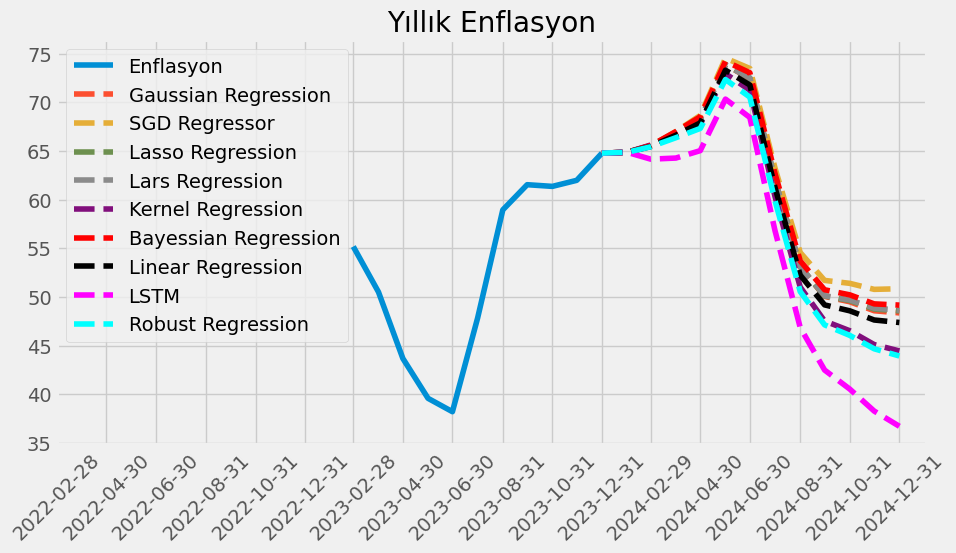

In [ ]:
plt.style.use("fivethirtyeight")
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
yıllıktahmin["Robust Regression"]=tüfetahmin22["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[13:24],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[23:-2],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[23:-2],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[23:-2],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[23:-2],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[23:-2],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[23:-2],'--',label="Bayessian Regression",color="red")
plt.plot(yıllıktahmin["Linear Regression"].iloc[23:-2],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[23:-2],'--',label="LSTM",color="magenta")
plt.plot(yıllıktahmin["Robust Regression"].iloc[23:-2],'--',label="Robust Regression",color="cyan")
plt.legend(loc=0)
plt.xticks(yıllıktahmin.index[1:-2:2],rotation=45)
#plt.xticks(pd.date_range(start="2022-12-30",end="2025-01-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [ ]:
yıllıktahmin["Maksimum"]=tüfetahmin23["CPI"]
yıllıktahmin["Minimum"]=tüfetahmin24["CPI"]
yıllıktahmin

,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Maksimum,Minimum
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494
2022-10-31,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786


In [ ]:
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:-2].mean(axis=1)
yıllıktahmin.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Maksimum,Minimum
2022-01-31,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824,48.690824
2022-02-28,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567,54.438567
2022-03-31,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538,61.144538
2022-04-30,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070,69.971070
2022-05-31,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950,73.495950
2022-06-30,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397,78.618397
2022-07-31,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053,79.602053
2022-08-31,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594,80.207594
2022-09-30,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494,83.452494
2022-10-31,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786,85.514786


In [ ]:
sonu2023=str(yıllıktahmin.iloc[23,0])[:5]
tepe=str(yıllıktahmin.iloc[28,0])[:5]
sonu2024=str(yıllıktahmin.iloc[35,0])[:5]
max=str(yıllıktahmin.iloc[-2,-3])[:5]
min=str(yıllıktahmin.iloc[-2,-2])[:5]


In [ ]:
min1=str(yıllıktahmin.iloc[35,-1])[:2]
max1=str(yıllıktahmin.iloc[35,-2])[:2]

In [ ]:
cariay=evds.get_data(["TP.PKAUO.S01.A.U"],startdate="01-11-2022",enddate="28-02-2024")
cariay=cariay.set_index(pd.date_range(start="2022-11-30",periods=16,freq="1M"))
del cariay["Tarih"]
cariay.columns=["Cari Ay Medyan Tahmin"]
cariay["TÜFE"]=df.iloc[-14:,0].shift(1).dropna()
cariay["Cari Ay Medyan Tahmin"]=1+(cariay["Cari Ay Medyan Tahmin"]/100)
cariay.iloc[-1,1]=1984.02
cariay["Enflasyon"]=cariay["Cari Ay Medyan Tahmin"]*cariay["TÜFE"]
cariay["TÜFE Önceki"]=df.iloc[-25:,0].shift(12).dropna()
cariay.iloc[-1,3]=1241.33
cariay["Enflasyon"]=((cariay["Enflasyon"]/cariay["TÜFE Önceki"])-1)*100
cariay

,Cari Ay Medyan Tahmin,TÜFE,Enflasyon,TÜFE Önceki
2022-11-30,1.0314,NaN,NaN,NaN
2022-12-31,1.0269,NaN,NaN,NaN
2023-01-31,1.0265,1128.45,51.769968,763.23
2023-02-28,1.0301,1203.48,54.976654,799.93
2023-03-31,1.0288,1241.33,51.377401,843.64
2023-04-30,1.0265,1269.75,44.055347,904.79
2023-05-31,1.0241,1300.04,42.887757,931.76
2023-06-30,1.0281,1300.60,36.736564,977.90
2023-07-31,1.0376,1351.59,40.096679,1001.03
2023-08-31,1.0554,1479.84,53.775724,1015.65


In [ ]:
ay1sonra=evds.get_data(["TP.PKAUO.S01.B.U"],startdate="01-01-2024",enddate="31-01-2024")
ay1sonra["TÜFE"]=2059.41
ay1sonra["TÜFE Yeni"]=(1+(ay1sonra["TP_PKAUO_S01_B_U"]/100))*ay1sonra["TÜFE"]
ay1sonra["TÜFE Eski"]=df.loc["2023-03-31"]["CPI"]
ay1sonra["Enflasyon"]=((ay1sonra["TÜFE Yeni"]/ay1sonra["TÜFE Eski"])-1)*100
ay1sonra

,Tarih,TP_PKAUO_S01_B_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2024-1,3.51,2059.41,2131.695291,1269.75,67.883071


In [ ]:
ay2sonra=evds.get_data(["TP.BEK.S01.C.U"],startdate="01-02-2024",enddate="31-12-2024")
ay2sonra["TÜFE"]=2126.96
ay2sonra["TÜFE Yeni"]=(1+(ay2sonra["TP_BEK_S01_C_U"]/100))*ay2sonra["TÜFE"]
ay2sonra["TÜFE Eski"]=df.loc["2023-04-30"]["CPI"]
ay2sonra["Enflasyon"]=((ay2sonra["TÜFE Yeni"]/ay2sonra["TÜFE Eski"])-1)*100
ay2sonra

,Tarih,TP_BEK_S01_C_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2024-2,3.28,2126.96,2196.724288,1300.04,68.973592


In [ ]:
ay12sonra=evds.get_data(["TP.PKAUO.S01.D.U"],startdate="01-02-2024",enddate="31-12-2024")
ay12sonra.columns=["Tarih","12 Ay Sonrası"]
ay12sonra

,Tarih,12 Ay Sonrası
0,2024-2,42.96


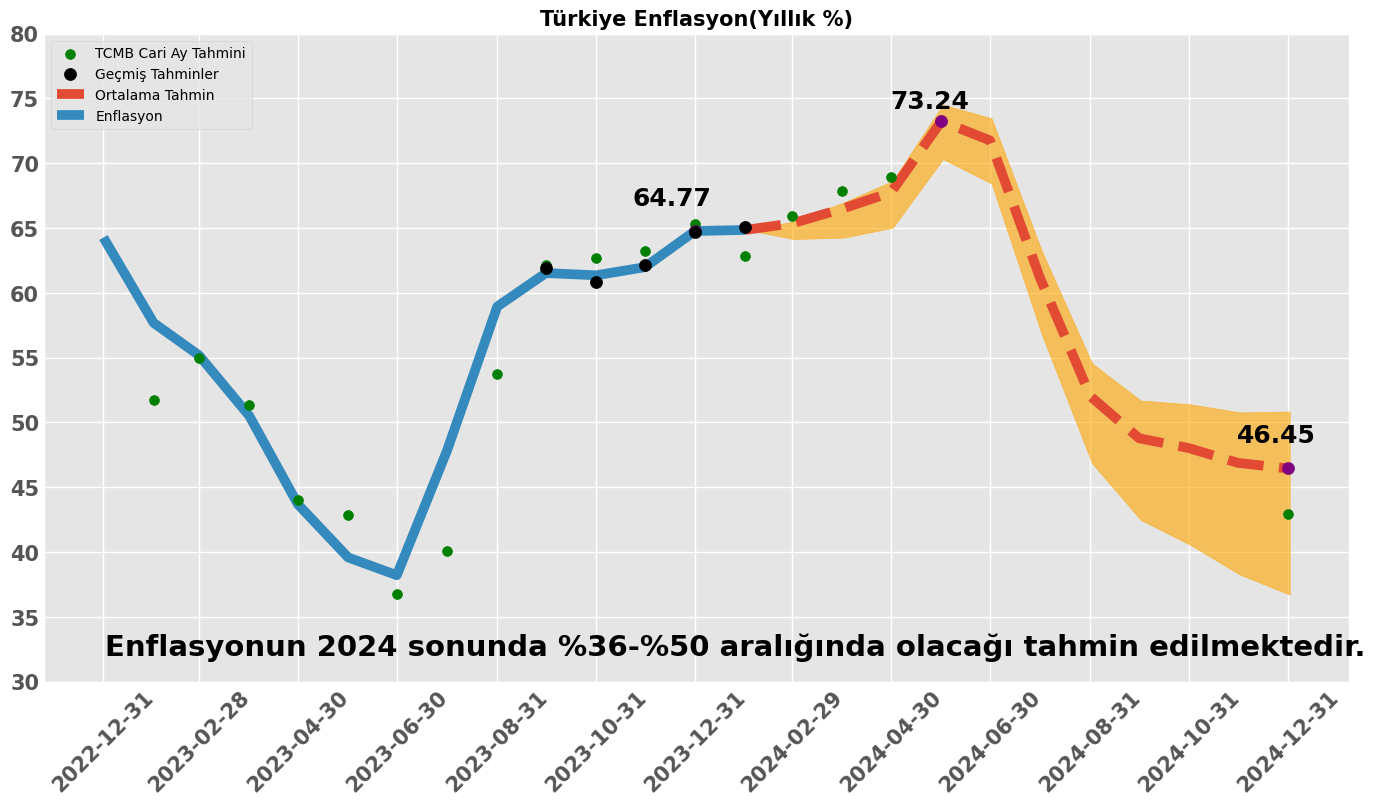

In [ ]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('ggplot')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-03-31"),y=ay1sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=pd.to_datetime("2024-04-30"),y=ay2sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=cariay[2:].index,y=cariay["Enflasyon"][2:].values,color="green",zorder=3,label='TCMB Cari Ay Tahmini',s=50)
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["12 Ay Sonrası"].values,color="green",zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[20:25],y=[61.94,60.84,62.13,64.71,65.06],color='black',zorder=4,label='Geçmiş Tahminler',s=75)
plt.scatter(x=yıllıktahmin.index[23],y=yıllıktahmin.iloc[23,0],color='purple',zorder=3,s=75)
plt.scatter(x=yıllıktahmin.index[28],y=yıllıktahmin.iloc[28,0],color='purple',zorder=3,s=75)
plt.scatter(x=yıllıktahmin.index[35],y=yıllıktahmin.iloc[35,0],color='purple',zorder=3,s=75)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[24:-2],'--',label="Ortalama Tahmin",linewidth=7)
plt.plot(yıllıktahmin["Ortalama"].iloc[11:25],label="Enflasyon",linewidth=7)
plt.fill_between(yıllıktahmin.iloc[24:-1].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[24:-1].shift(1), yıllıktahmin["Minimum"].iloc[24:-1].shift(1), alpha=0.6, color='orange')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2025-02')
plt.text(mdates.datestr2num('2023-12'), float(sonu2023)+2, sonu2023, fontsize=18, color='black', horizontalalignment='center',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+1, tepe, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+2, sonu2024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2026-01'), float(sonu2024)-5, sonu2025, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[11:37:2],rotation=45,fontsize=15,fontweight="bold")
plt.yticks(np.arange(30,85,5),fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=2)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01')])

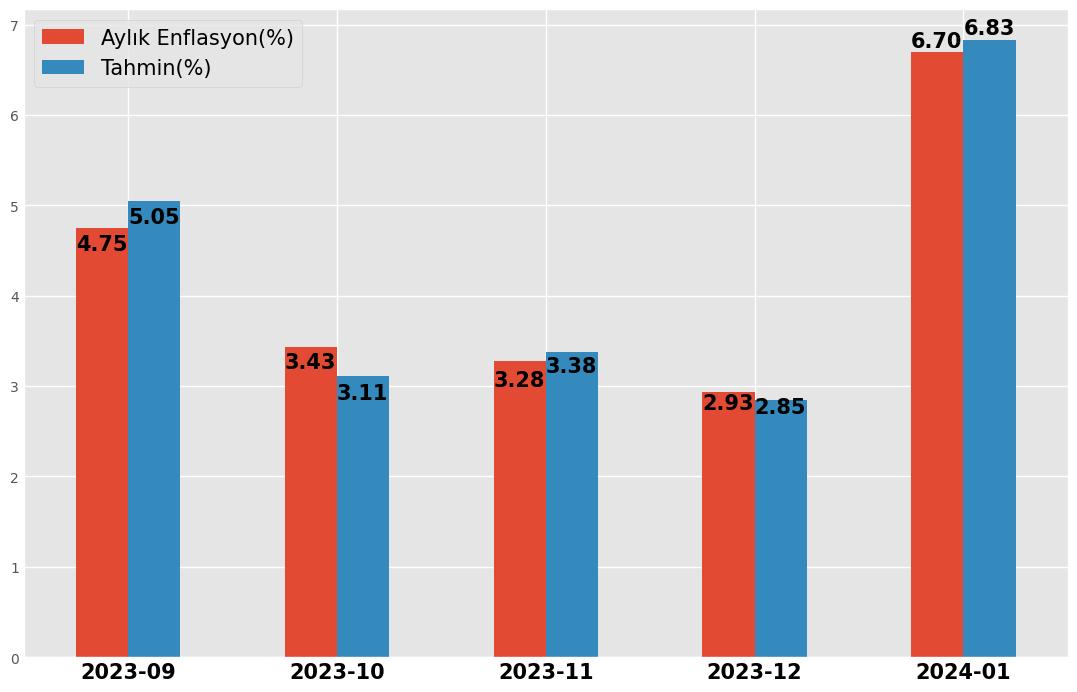

In [ ]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=5,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(12,8))
plt.annotate("4.75",xy=(-0.25,4.5),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,4.8),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.75,3.2),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,2.85),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.75,3),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,3.15),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.75,2.75),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,2.7),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.75,6.75),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,6.90),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=0,fontweight="bold",fontsize=15,color="black")

In [ ]:
aralık=aylıktahmin.iloc[0,-1]
aralık = "{:.2f}".format(aralık)
sonu2023=yıllıktahmin.loc["2023-12-31","Ortalama"]
sonu2023="{:.2f}".format(sonu2023)
sonu2024=yıllıktahmin.loc["2024-12-31","Ortalama"]
sonu2024="{:.2f}".format(sonu2024)


Text(10.75, 4.260416527783661, '4.48')

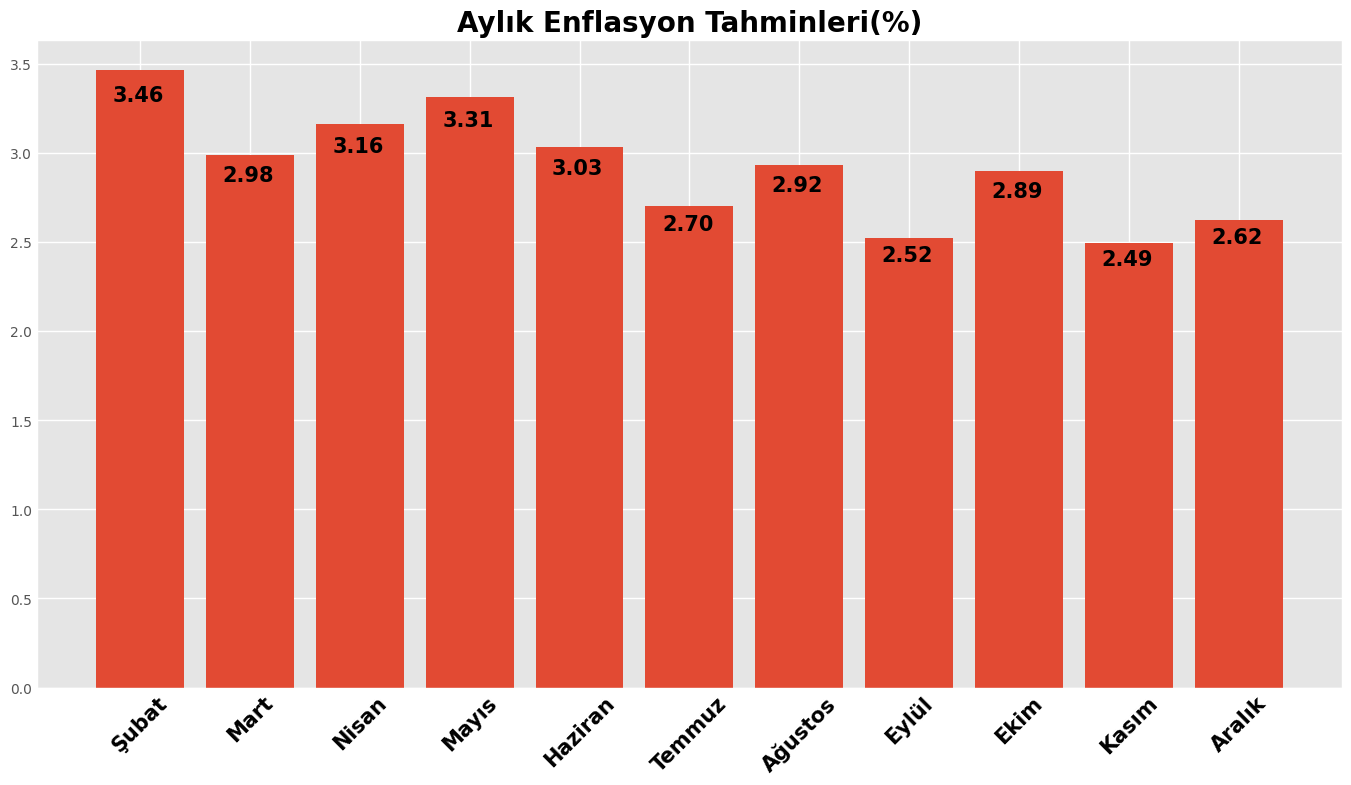

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(x=["Şubat","Mart","Nisan","Mayıs","Haziran","Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık"],height=aylıktahmin.iloc[:-2,-3])
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0,-3])[:4],xy=(-0.25,aylıktahmin.iloc[0,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1,-3])[:4],xy=(0.75,aylıktahmin.iloc[1,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2,-3])[:4],xy=(1.75,aylıktahmin.iloc[2,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3,-3])[:4],xy=(2.75,aylıktahmin.iloc[3,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4,-3])[:4],xy=(3.75,aylıktahmin.iloc[4,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5,-3])[:4],xy=(4.75,aylıktahmin.iloc[5,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6,-3])[:4],xy=(5.75,aylıktahmin.iloc[6,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7,-3])[:4],xy=(6.75,aylıktahmin.iloc[7,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8,-3])[:4],xy=(7.75,aylıktahmin.iloc[8,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9,-3])[:4],xy=(8.75,aylıktahmin.iloc[9,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[10,-3])[:4],xy=(9.75,aylıktahmin.iloc[10,-3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[11,-3])[:4],xy=(10.75,aylıktahmin.iloc[11,-3]*0.95),fontweight="bold",fontsize=15)

In [1669]:
for column in ['USD/TL', 'Motorin',  'Enflasyon Belirsizliği', 'ParaArzi',
       'Borç', 'Kredi']:
    mevsimsellik[f"{column}_mevsimsellik"]=(seasonal_decompose(data[column]).seasonal).tail(12)
    data[column]=data[column]-(seasonal_decompose(data[column]).seasonal)


In [1673]:
mevsimsellik[f"{column}_mevsimsellik"].tail(12)

Tarih
2023-02-28   -0.947164
2023-03-31   -1.081976
2023-04-30   -0.378994
2023-05-31    0.673430
2023-06-30    0.607747
2023-07-31    0.207899
2023-08-31   -0.183403
2023-09-30    0.301581
2023-10-31    0.506834
2023-11-30    0.011316
2023-12-31    0.437690
2024-01-31   -0.154960
Freq: M, Name: USD/TL_mevsimsellik, dtype: float64

In [1672]:
tahmindf[column].iloc[:-2]

2024-02-29    2.221133
2024-03-31    2.458005
2024-04-30    2.064308
2024-05-31    2.194014
2024-06-30    2.123574
2024-07-31    2.102267
2024-08-31    2.058982
2024-09-30    2.017443
2024-10-31    1.977547
2024-11-30    1.918120
2024-12-31    1.902702
2025-01-31    1.867176
Freq: M, Name: USD/TL, dtype: float64

In [1674]:
for column in ['USD/TL', 'Motorin',  'Enflasyon Belirsizliği', 'ParaArzi',
       'Borç', 'Kredi']:
    tahmindf[column].iloc[:-2]=tahmindf[column].iloc[:-2]-mevsimsellik[f"{column}_mevsimsellik"].tail(12).values

In [1690]:
features=['USD/TL', 'Motorin', 'Zam',  'Enflasyon Belirsizliği',
       'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT',
       'İşsizlik', 'Politika Faizi']
X=data[features]
y=data["TÜFE"]
y_pred1=pd.DataFrame(index=pd.date_range(start="2024-02-28",freq="M",periods=14))
for r in range(3, 13):
        for combo in combinations(features, r):
            selected_features = list(combo)
            if 'Zam' not in selected_features:
                  selected_features.append('Zam')
            X_subset = X[selected_features]
            model=LinearRegression()
            model.fit(X_subset, y)
            y_pred1[f'Tahmin_{r}_{selected_features}'] = model.predict(np.array(tahmindf[selected_features]))

In [1688]:
new_df = pd.DataFrame()
for index, row in y_pred1.iterrows():
    # Satırdaki eşik değerleri belirleyelim
    thresholds = row.quantile(0.75)
    
    # Satırdaki değerleri eşik değerleri ile karşılaştırarak işlem yapalım
    filtered_row = row <= thresholds
    
    # Yeni DataFrame'e ekleyelim
    new_df = pd.concat([new_df, pd.DataFrame(filtered_row).transpose()], ignore_index=True)
cols=new_df[new_df==True].dropna(axis=1).columns
y_pred1=y_pred1[cols.values]